In [7]:
import osmium
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from shapely.geometry import Point, Polygon
from shapely import wkt
import pyproj
import time
from tqdm import tqdm
import ast
import json
from collections import Counter
import numpy as np
import warnings
from datetime import datetime

## Phas 1: Environment Setup and Data Ingestion
- **Objective:** To extract relevant address and building information from the raw .pbf file into a more manageable format.

In [8]:
class BuildingAddrHandler(osmium.SimpleHandler):
    def __init__(self):
        super().__init__()
        self.data = []
        self.processed_nodes = 0
        self.processed_ways = 0
        self.matched_elements = 0
        self.start_time = time.time()

    def node(self, n):
        self.processed_nodes += 1
        if self.processed_nodes % 100000 == 0:  # Progress every 100k nodes
            elapsed = time.time() - self.start_time
            print(f"Processed {self.processed_nodes:,} nodes, {self.matched_elements:,} matches in {elapsed:.1f}s")
        
        tags = dict(n.tags)
        if 'building' in tags or any(k.startswith('addr:') for k in tags):
            self.matched_elements += 1
            self.data.append({
                'id': n.id,
                'type': 'node',
                'tags': tags,
                'geometry': Point(n.location.lon, n.location.lat) if n.location.valid() else None
            })

    def way(self, w):
        self.processed_ways += 1
        if self.processed_ways % 10000 == 0:  # Progress every 10k ways
            elapsed = time.time() - self.start_time
            print(f"Processed {self.processed_ways:,} ways, {self.matched_elements:,} total matches in {elapsed:.1f}s")
        
        tags = dict(w.tags)
        if 'building' in tags or any(k.startswith('addr:') for k in tags):
            self.matched_elements += 1
            coords = [(n.lon, n.lat) for n in w.nodes if n.location.valid()]
            geom = None
            if len(coords) > 2:
                try:
                    poly = Polygon(coords)
                    geom = poly.centroid
                except Exception:
                    geom = None
            self.data.append({
                'id': w.id,
                'type': 'way',
                'tags': tags,
                'geometry': geom
            })

""" print("Starting OSM data extraction...")
print("This may take 15-60 minutes for a 372MB file. Progress will be shown every 100k nodes/10k ways.")

pbf_path = 'portugal-250902.osm.pbf'

handler = BuildingAddrHandler()
start_time = time.time()
handler.apply_file(pbf_path, locations=True)
processing_time = time.time() - start_time

print(f"\nExtraction completed in {processing_time:.1f} seconds ({processing_time/60:.1f} minutes)")
print(f"Total nodes processed: {handler.processed_nodes:,}")
print(f"Total ways processed: {handler.processed_ways:,}")
print(f"Total matching elements found: {handler.matched_elements:,}")

print("\nConverting to DataFrame...")
df = pd.DataFrame([
    {
        'id': d['id'],
        'type': d['type'],
        'tags': str(d['tags']),  # Convert tags dict to string for better compatibility
        'geometry': d['geometry'].wkt if d['geometry'] is not None else None
    }
    for d in handler.data
])

print(f"DataFrame created with {len(df):,} rows")

# Try to save as Parquet first, fallback to CSV if needed
try:
    print("Saving to Parquet...")
    df.to_parquet('filtered_osm_buildings.parquet')
    print("✅ Extraction complete! File saved as 'filtered_osm_buildings.parquet'")
except ImportError as e:
    print(f"Parquet not available ({e}), saving as CSV instead...")
    df.to_csv('filtered_osm_buildings.csv', index=False)
    print("✅ Extraction complete! File saved as 'filtered_osm_buildings.csv'") """

' print("Starting OSM data extraction...")\nprint("This may take 15-60 minutes for a 372MB file. Progress will be shown every 100k nodes/10k ways.")\n\npbf_path = \'portugal-250902.osm.pbf\'\n\nhandler = BuildingAddrHandler()\nstart_time = time.time()\nhandler.apply_file(pbf_path, locations=True)\nprocessing_time = time.time() - start_time\n\nprint(f"\nExtraction completed in {processing_time:.1f} seconds ({processing_time/60:.1f} minutes)")\nprint(f"Total nodes processed: {handler.processed_nodes:,}")\nprint(f"Total ways processed: {handler.processed_ways:,}")\nprint(f"Total matching elements found: {handler.matched_elements:,}")\n\nprint("\nConverting to DataFrame...")\ndf = pd.DataFrame([\n    {\n        \'id\': d[\'id\'],\n        \'type\': d[\'type\'],\n        \'tags\': str(d[\'tags\']),  # Convert tags dict to string for better compatibility\n        \'geometry\': d[\'geometry\'].wkt if d[\'geometry\'] is not None else None\n    }\n    for d in handler.data\n])\n\nprint(f"DataFr

# Phase 2: Macro Analysis - The Big Picture 🗺️

**Objective:** Understand the overall scale, composition, and quality of the extracted OSM dataset.

This phase will provide:
- Dataset scale and element distribution
- Tag frequency analysis and data profiling
- Address data coverage and completeness
- Geographic distribution insights
- Data quality assessment
- Building type analysis

In [9]:
# Load the extracted data
try:
    df = pd.read_parquet('../data/filtered_osm_buildings.parquet')
    print("✅ Loaded data from Parquet file")
except:
    df = pd.read_csv('../data/filtered_osm_buildings.csv')
    print("✅ Loaded data from CSV file")

print(f"\n📊 DATASET OVERVIEW")
print(f"{'='*50}")
print(f"Total elements extracted: {len(df):,}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"Data types: {df.dtypes.to_dict()}")

type_counts = df['type'].value_counts()
print(f"\n🏗️ ELEMENT TYPE DISTRIBUTION")
print(f"{'='*50}")
for elem_type, count in type_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{elem_type.capitalize()}s: {count:,} ({percentage:.1f}%)")

print(f"\n📋 DATA SAMPLE")
print(f"{'='*50}")
print(df.head())

✅ Loaded data from Parquet file

📊 DATASET OVERVIEW
Total elements extracted: 2,554,600
Memory usage: 717.3 MB
Data types: {'id': dtype('int64'), 'type': dtype('O'), 'tags': dtype('O'), 'geometry': dtype('O')}

🏗️ ELEMENT TYPE DISTRIBUTION
Ways: 2,041,373 (79.9%)
Nodes: 513,227 (20.1%)

📋 DATA SAMPLE
          id  type                                               tags  \
0   25624123  node  {'addr:postcode': '5430-403', 'capital': '7', ...   
1   26860417  node  {'access': 'customers', 'addr:city': 'Braga', ...   
2   31236403  node  {'addr:postcode': '3600-011', 'name': 'Bustelo...   
3   46756926  node  {'addr:city': 'Faro', 'addr:postcode': '8000-1...   
4  196096846  node  {'addr:city': 'Sesimbra', 'addr:street': 'Aven...   

                        geometry  
0  POINT (-7.3108525 41.6067883)  
1  POINT (-8.4219647 41.5385285)  
2  POINT (-7.7728608 40.9674808)  
3   POINT (-7.940441 37.0192583)  
4  POINT (-9.1308072 38.4483021)  
Memory usage: 717.3 MB
Data types: {'id': dtype('

In [10]:
# Tag Frequency Analysis
def parse_tags(tags_str):
    """Parse tags string back to dictionary"""
    try:
        if pd.isna(tags_str) or tags_str == '{}':
            return {}
        # Handle string representation of dict
        if isinstance(tags_str, str):
            return ast.literal_eval(tags_str)
        return tags_str
    except:
        return {}

print("🏷️ PARSING TAGS...")
df['parsed_tags'] = df['tags'].apply(parse_tags)

all_tag_keys = []
all_tag_values = []
tag_key_value_pairs = []

for tags_dict in df['parsed_tags']:
    if isinstance(tags_dict, dict):
        for key, value in tags_dict.items():
            all_tag_keys.append(key)
            all_tag_values.append(value)
            tag_key_value_pairs.append(f"{key}={value}")

# Tag key frequency analysis
tag_key_counts = Counter(all_tag_keys)
print(f"\n🔑 TOP 30 MOST COMMON TAG KEYS")
print(f"{'='*60}")
print(f"{'Rank':<4} {'Key':<25} {'Count':<10} {'Percentage'}")
print(f"{'-'*60}")

for i, (key, count) in enumerate(tag_key_counts.most_common(30), 1):
    percentage = (count / len(df)) * 100
    print(f"{i:<4} {key:<25} {count:<10,} {percentage:.1f}%")

# Tag value frequency for key tags
print(f"\n🏠 BUILDING TYPE ANALYSIS")
print(f"{'='*50}")
building_tags = [tags for tags in df['parsed_tags'] if isinstance(tags, dict) and 'building' in tags]
building_values = [tags['building'] for tags in building_tags]
building_counts = Counter(building_values)

print(f"Total elements with 'building' tag: {len(building_tags):,}")
print(f"\nTop 15 building types:")
for i, (building_type, count) in enumerate(building_counts.most_common(15), 1):
    percentage = (count / len(building_tags)) * 100
    print(f"{i:2}. {building_type:<20} {count:>6,} ({percentage:4.1f}%)")

🏷️ PARSING TAGS...

🔑 TOP 30 MOST COMMON TAG KEYS
Rank Key                       Count      Percentage
------------------------------------------------------------
1    building                  2,025,546  79.3%
2    addr:street               591,663    23.2%
3    addr:housenumber          555,919    21.8%
4    addr:postcode             528,757    20.7%
5    addr:city                 456,627    17.9%
6    note                      172,591    6.8%
7    source                    139,904    5.5%
8    name                      108,563    4.2%
9    building:levels           93,175     3.6%
10   fixme                     68,493     2.7%
11   amenity                   62,799     2.5%
12   addr:housename            51,312     2.0%
13   addr:unit                 40,772     1.6%
14   addr:country              38,524     1.5%
15   addr:floor                36,909     1.4%
16   operator                  30,400     1.2%
17   ogr_pkid                  28,349     1.1%
18   opening_hours             2

In [11]:
# Address Data Scope Analysis
def has_address_tag(tags_dict):
    """Check if element has any addr:* tag"""
    if not isinstance(tags_dict, dict):
        return False
    return any(key.startswith('addr:') for key in tags_dict.keys())

def has_building_tag(tags_dict):
    """Check if element has building tag"""
    if not isinstance(tags_dict, dict):
        return False
    return 'building' in tags_dict

# Analyze address coverage
df['has_address'] = df['parsed_tags'].apply(has_address_tag)
df['has_building'] = df['parsed_tags'].apply(has_building_tag)

print(f"🏠 ADDRESS DATA SCOPE ANALYSIS")
print(f"{'='*60}")

# Overall statistics
total_elements = len(df)
elements_with_addresses = df['has_address'].sum()
elements_with_buildings = df['has_building'].sum()
buildings_with_addresses = df[df['has_building'] & df['has_address']].shape[0]

print(f"Total extracted elements: {total_elements:,}")
print(f"Elements with addr:* tags: {elements_with_addresses:,} ({elements_with_addresses/total_elements*100:.1f}%)")
print(f"Elements with building tags: {elements_with_buildings:,} ({elements_with_buildings/total_elements*100:.1f}%)")
print(f"Buildings with address info: {buildings_with_addresses:,} ({buildings_with_addresses/elements_with_buildings*100:.1f}% of buildings)")

# Address completeness matrix
print(f"\n📊 ADDRESS vs BUILDING MATRIX")
print(f"{'='*50}")
cross_tab = pd.crosstab(df['has_building'], df['has_address'], margins=True)
cross_tab.index = ['No Building Tag', 'Has Building Tag', 'Total']
cross_tab.columns = ['No Address', 'Has Address', 'Total']
print(cross_tab)

# Analyze specific address tag types
addr_tag_types = []
for tags_dict in df['parsed_tags']:
    if isinstance(tags_dict, dict):
        for key in tags_dict.keys():
            if key.startswith('addr:'):
                addr_tag_types.append(key)

addr_tag_counts = Counter(addr_tag_types)
print(f"\n🏷️ ADDRESS TAG TYPE FREQUENCY")
print(f"{'='*50}")
print(f"Total address tags found: {len(addr_tag_types):,}")
print(f"\nTop 15 address tag types:")
for i, (tag_type, count) in enumerate(addr_tag_counts.most_common(15), 1):
    percentage = (count / elements_with_addresses) * 100
    print(f"{i:2}. {tag_type:<20} {count:>6,} ({percentage:4.1f}% of addressed elements)")

🏠 ADDRESS DATA SCOPE ANALYSIS
Total extracted elements: 2,554,600
Elements with addr:* tags: 651,161 (25.5%)
Elements with building tags: 2,025,546 (79.3%)
Buildings with address info: 122,107 (6.0% of buildings)

📊 ADDRESS vs BUILDING MATRIX
                  No Address  Has Address    Total
No Building Tag            0       529054   529054
Has Building Tag     1903439       122107  2025546
Total                1903439       651161  2554600
                  No Address  Has Address    Total
No Building Tag            0       529054   529054
Has Building Tag     1903439       122107  2025546
Total                1903439       651161  2554600

🏷️ ADDRESS TAG TYPE FREQUENCY
Total address tags found: 2,322,616

Top 15 address tag types:
 1. addr:street          591,663 (90.9% of addressed elements)
 2. addr:housenumber     555,919 (85.4% of addressed elements)
 3. addr:postcode        528,757 (81.2% of addressed elements)
 4. addr:city            456,627 (70.1% of addressed elements)
 5.

In [12]:
# Geographic Distribution Analysis
warnings.filterwarnings('ignore')

def parse_geometry(geom_str):
    """Parse WKT geometry string"""
    try:
        if pd.isna(geom_str) or geom_str is None:
            return None
        return wkt.loads(geom_str)
    except:
        return None

print(f"🌍 GEOGRAPHIC DISTRIBUTION ANALYSIS")
print(f"{'='*60}")

# Parse geometries
print("Parsing geometries...")
df['geometry_parsed'] = df['geometry'].apply(parse_geometry)
valid_geometries = df['geometry_parsed'].notna()

print(f"Elements with valid geometry: {valid_geometries.sum():,} ({valid_geometries.sum()/len(df)*100:.1f}%)")

# Extract coordinates for valid geometries
coordinates = []
for geom in df[valid_geometries]['geometry_parsed']:
    if geom is not None:
        if hasattr(geom, 'x') and hasattr(geom, 'y'):  # Point
            coordinates.append((geom.x, geom.y))
        elif hasattr(geom, 'coords'):  # Other geometry types
            coordinates.extend(list(geom.coords))

if coordinates:
    lons, lats = zip(*coordinates)
    
    print(f"\n📍 COORDINATE BOUNDS")
    print(f"{'='*40}")
    print(f"Longitude range: {min(lons):.6f} to {max(lons):.6f}")
    print(f"Latitude range:  {min(lats):.6f} to {max(lats):.6f}")
    print(f"Center point: ({np.mean(lons):.6f}, {np.mean(lats):.6f})")
    
    # Rough geographic extent
    lon_span = max(lons) - min(lons)
    lat_span = max(lats) - min(lats)
    print(f"Approximate coverage: {lon_span:.3f}° x {lat_span:.3f}°")
    
    # Element density by coordinate grid (rough)
    print(f"\n🗺️ SPATIAL DENSITY ANALYSIS")
    print(f"{'='*40}")
    
    # Create simple grid analysis
    lon_bins = np.linspace(min(lons), max(lons), 11)  # 10x10 grid
    lat_bins = np.linspace(min(lats), max(lats), 11)
    
    # Count elements in each grid cell
    grid_counts = []
    for i in range(len(lon_bins)-1):
        for j in range(len(lat_bins)-1):
            count = sum(1 for lon, lat in coordinates 
                       if lon_bins[i] <= lon < lon_bins[i+1] and lat_bins[j] <= lat < lat_bins[j+1])
            if count > 0:
                grid_counts.append(count)
    
    if grid_counts:
        print(f"Grid cells with data: {len(grid_counts)}/100")
        print(f"Average elements per populated cell: {np.mean(grid_counts):.0f}")
        print(f"Max elements in single cell: {max(grid_counts):,}")
        print(f"Min elements in populated cell: {min(grid_counts):,}")
else:
    print("❌ No valid coordinates found for analysis")

🌍 GEOGRAPHIC DISTRIBUTION ANALYSIS
Parsing geometries...
Elements with valid geometry: 2,554,383 (100.0%)
Elements with valid geometry: 2,554,383 (100.0%)

📍 COORDINATE BOUNDS
Longitude range: -31.266329 to -6.183476
Latitude range:  32.513255 to 42.159683
Center point: (-10.127759, 38.833448)

📍 COORDINATE BOUNDS
Longitude range: -31.266329 to -6.183476
Latitude range:  32.513255 to 42.159683
Center point: (-10.127759, 38.833448)
Approximate coverage: 25.083° x 9.646°

🗺️ SPATIAL DENSITY ANALYSIS
Approximate coverage: 25.083° x 9.646°

🗺️ SPATIAL DENSITY ANALYSIS
Grid cells with data: 18/100
Average elements per populated cell: 141910
Max elements in single cell: 516,181
Min elements in populated cell: 1,685
Grid cells with data: 18/100
Average elements per populated cell: 141910
Max elements in single cell: 516,181
Min elements in populated cell: 1,685


In [13]:
# Data Quality Assessment
print(f"🔍 DATA QUALITY ASSESSMENT")
print(f"{'='*60}")

# Missing data analysis
print(f"📊 MISSING DATA ANALYSIS")
print(f"{'='*40}")
missing_stats = {
    'Total elements': len(df),
    'Missing geometry': df['geometry'].isna().sum(),
    'Missing tags': df['tags'].isna().sum(),
    'Empty tag dictionaries': sum(1 for tags in df['parsed_tags'] if not tags or tags == {}),
}

for metric, count in missing_stats.items():
    if 'Total' in metric:
        print(f"{metric}: {count:,}")
    else:
        percentage = (count / len(df)) * 100
        print(f"{metric}: {count:,} ({percentage:.1f}%)")

# Tag completeness for buildings
buildings_df = df[df['has_building']].copy()
if len(buildings_df) > 0:
    print(f"\n🏗️ BUILDING DATA COMPLETENESS")
    print(f"{'='*40}")
    
    # Common building attributes
    building_attributes = [
        ('addr:housenumber', 'House numbers'),
        ('addr:street', 'Street names'),
        ('addr:city', 'City names'),
        ('addr:postcode', 'Postal codes'),
        ('building:levels', 'Building levels'),
        ('name', 'Building names'),
        ('amenity', 'Amenity type'),
    ]
    
    for attr, description in building_attributes:
        count = sum(1 for tags in buildings_df['parsed_tags'] 
                   if isinstance(tags, dict) and attr in tags)
        percentage = (count / len(buildings_df)) * 100
        print(f"{description:<20}: {count:>6,} ({percentage:4.1f}% of buildings)")

# Address completeness analysis
print(f"\n📮 ADDRESS COMPLETENESS ANALYSIS")
print(f"{'='*40}")

addressed_buildings = df[df['has_building'] & df['has_address']].copy()
if len(addressed_buildings) > 0:
    print(f"Buildings with addresses: {len(addressed_buildings):,}")
    
    # Check for complete addresses (street + number)
    complete_addresses = 0
    partial_addresses = 0
    
    for tags in addressed_buildings['parsed_tags']:
        if isinstance(tags, dict):
            has_street = 'addr:street' in tags
            has_number = 'addr:housenumber' in tags
            
            if has_street and has_number:
                complete_addresses += 1
            elif has_street or has_number:
                partial_addresses += 1
    
    print(f"Complete addresses (street + number): {complete_addresses:,} ({complete_addresses/len(addressed_buildings)*100:.1f}%)")
    print(f"Partial addresses (street OR number): {partial_addresses:,} ({partial_addresses/len(addressed_buildings)*100:.1f}%)")

# Source attribution analysis
print(f"\n📝 DATA SOURCE ANALYSIS")
print(f"{'='*40}")

source_tags = []
for tags_dict in df['parsed_tags']:
    if isinstance(tags_dict, dict) and 'source' in tags_dict:
        source_tags.append(tags_dict['source'])

if source_tags:
    source_counts = Counter(source_tags)
    print(f"Elements with source attribution: {len(source_tags):,} ({len(source_tags)/len(df)*100:.1f}%)")
    print(f"\nTop 10 data sources:")
    for i, (source, count) in enumerate(source_counts.most_common(10), 1):
        percentage = (count / len(source_tags)) * 100
        # Truncate long source strings
        source_display = source[:50] + "..." if len(source) > 50 else source
        print(f"{i:2}. {source_display:<53} {count:>6,} ({percentage:4.1f}%)")
else:
    print("No source attribution found in the data")

🔍 DATA QUALITY ASSESSMENT
📊 MISSING DATA ANALYSIS
Total elements: 2,554,600
Missing geometry: 217 (0.0%)
Missing tags: 0 (0.0%)
Empty tag dictionaries: 0 (0.0%)
Total elements: 2,554,600
Missing geometry: 217 (0.0%)
Missing tags: 0 (0.0%)
Empty tag dictionaries: 0 (0.0%)

🏗️ BUILDING DATA COMPLETENESS

🏗️ BUILDING DATA COMPLETENESS
House numbers       : 98,314 ( 4.9% of buildings)
House numbers       : 98,314 ( 4.9% of buildings)
Street names        : 105,035 ( 5.2% of buildings)
Street names        : 105,035 ( 5.2% of buildings)
City names          : 73,710 ( 3.6% of buildings)
City names          : 73,710 ( 3.6% of buildings)
Postal codes        : 63,023 ( 3.1% of buildings)
Postal codes        : 63,023 ( 3.1% of buildings)
Building levels     : 88,577 ( 4.4% of buildings)
Building levels     : 88,577 ( 4.4% of buildings)
Building names      : 47,508 ( 2.3% of buildings)
Building names      : 47,508 ( 2.3% of buildings)
Amenity type        : 25,717 ( 1.3% of buildings)

📮 ADDRESS COM

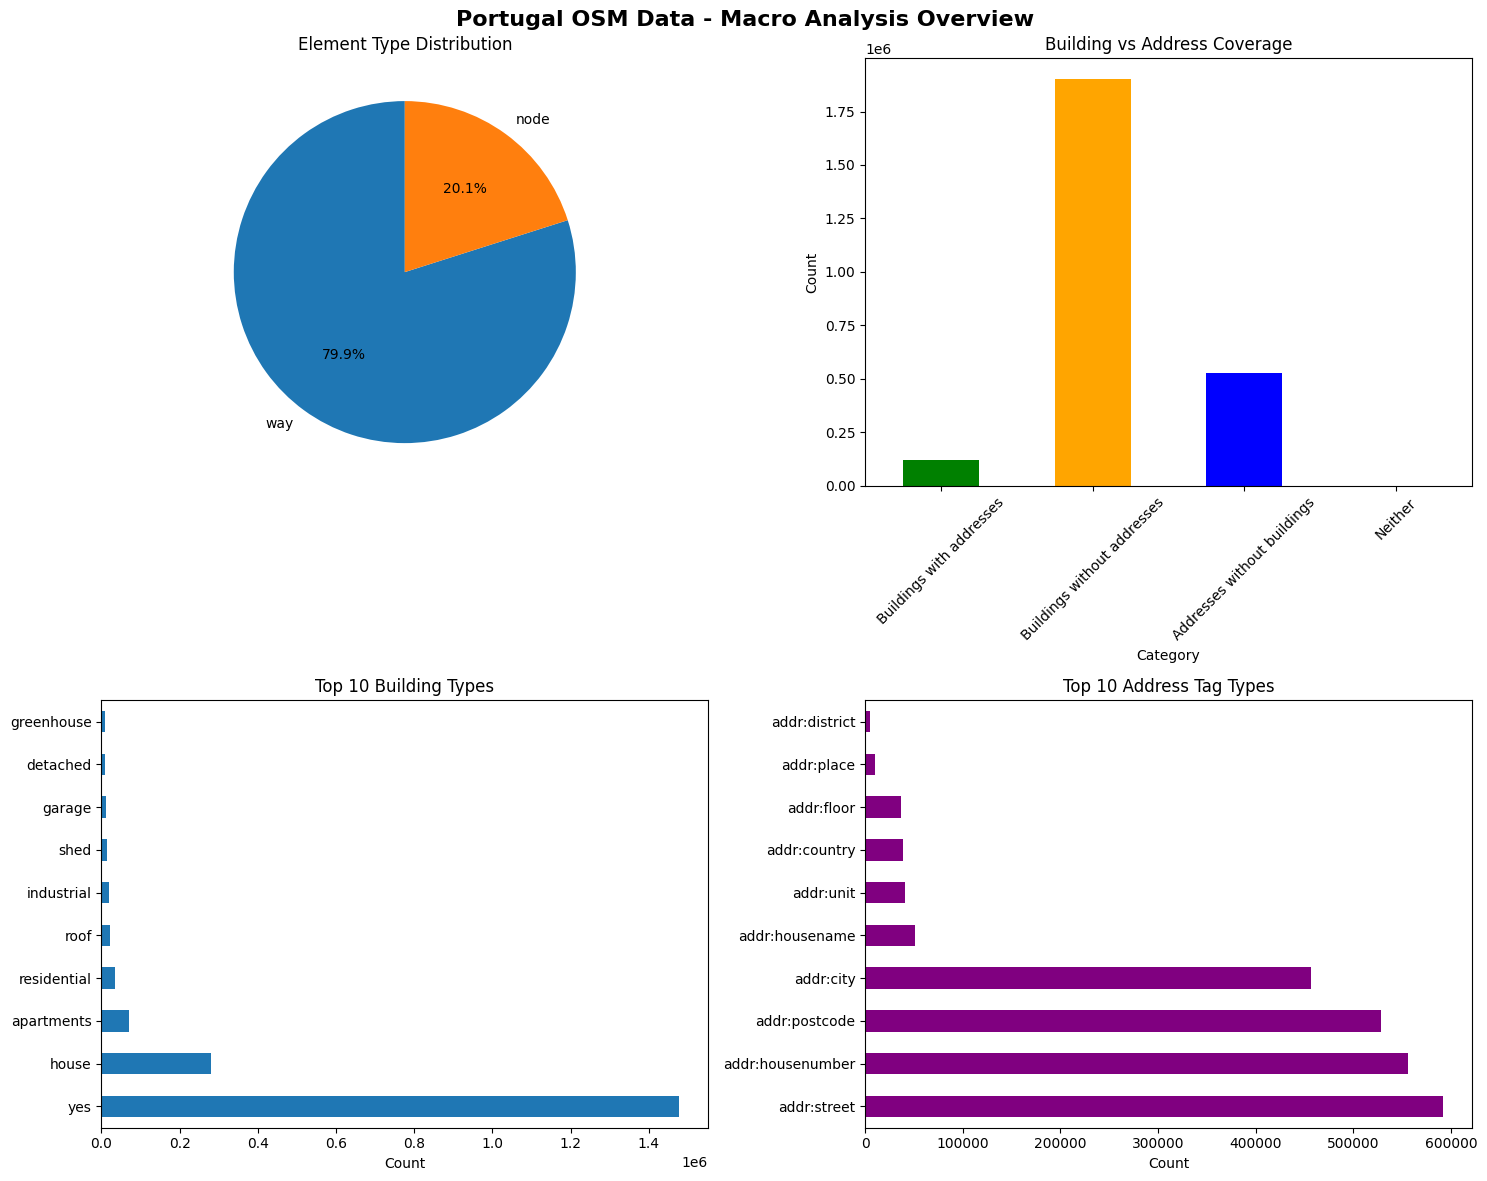


📋 PHASE 2 SUMMARY REPORT
Dataset Scale:
  • Total elements extracted: 2,554,600
  • Nodes: 513,227, Ways: 2,041,373
  • Memory footprint: 1424.8 MB

Address Coverage:
  • Elements with addresses: 651,161 (25.5%)
  • Buildings with addresses: 122,107 (6.0% of buildings)
  • Address completeness (street+number): 87944

Data Quality:
  • Valid geometries: 2,554,383 (100.0%)
  • Source attribution: 139,904 elements
  • Most common building type: yes

Key Insights:
  ⚠️  Low address coverage: Only 6.0% of buildings have addresses
  ✅ Excellent geometry data: 100.0% valid

🎯 Ready for Phase 3: Detailed Analysis and Quality Assessment


In [14]:
# Visualizations and Summary
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Portugal OSM Data - Macro Analysis Overview', fontsize=16, fontweight='bold')

# Element type distribution
ax1 = axes[0, 0]
type_counts.plot(kind='pie', ax=ax1, autopct='%1.1f%%', startangle=90)
ax1.set_title('Element Type Distribution')
ax1.set_ylabel('')

# Building vs Address coverage
ax2 = axes[0, 1]
coverage_data = {
    'Buildings with addresses': buildings_with_addresses,
    'Buildings without addresses': elements_with_buildings - buildings_with_addresses,
    'Addresses without buildings': elements_with_addresses - buildings_with_addresses,
    'Neither': total_elements - elements_with_buildings - elements_with_addresses + buildings_with_addresses
}
coverage_series = pd.Series(coverage_data)
coverage_series.plot(kind='bar', ax=ax2, color=['green', 'orange', 'blue', 'red'])
ax2.set_title('Building vs Address Coverage')
ax2.set_xlabel('Category')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Top building types
ax3 = axes[1, 0]
if building_counts:
    top_buildings = dict(building_counts.most_common(10))
    pd.Series(top_buildings).plot(kind='barh', ax=ax3)
    ax3.set_title('Top 10 Building Types')
    ax3.set_xlabel('Count')

# Top address tag types
ax4 = axes[1, 1]
if addr_tag_counts:
    top_addr_tags = dict(addr_tag_counts.most_common(10))
    pd.Series(top_addr_tags).plot(kind='barh', ax=ax4, color='purple')
    ax4.set_title('Top 10 Address Tag Types')
    ax4.set_xlabel('Count')

plt.tight_layout()
plt.show()

# Final Summary Report
print(f"\n📋 PHASE 2 SUMMARY REPORT")
print(f"{'='*80}")
print(f"Dataset Scale:")
print(f"  • Total elements extracted: {total_elements:,}")
print(f"  • Nodes: {type_counts.get('node', 0):,}, Ways: {type_counts.get('way', 0):,}")
print(f"  • Memory footprint: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\nAddress Coverage:")
print(f"  • Elements with addresses: {elements_with_addresses:,} ({elements_with_addresses/total_elements*100:.1f}%)")
print(f"  • Buildings with addresses: {buildings_with_addresses:,} ({buildings_with_addresses/elements_with_buildings*100:.1f}% of buildings)")
print(f"  • Address completeness (street+number): {complete_addresses if 'complete_addresses' in locals() else 'N/A'}")

print(f"\nData Quality:")
print(f"  • Valid geometries: {valid_geometries.sum():,} ({valid_geometries.sum()/len(df)*100:.1f}%)")
print(f"  • Source attribution: {len(source_tags) if source_tags else 0:,} elements")
print(f"  • Most common building type: {building_counts.most_common(1)[0][0] if building_counts else 'N/A'}")

print(f"\nKey Insights:")
if buildings_with_addresses/elements_with_buildings < 0.5:
    print(f"  ⚠️  Low address coverage: Only {buildings_with_addresses/elements_with_buildings*100:.1f}% of buildings have addresses")
else:
    print(f"  ✅ Good address coverage: {buildings_with_addresses/elements_with_buildings*100:.1f}% of buildings have addresses")

if valid_geometries.sum()/len(df) > 0.95:
    print(f"  ✅ Excellent geometry data: {valid_geometries.sum()/len(df)*100:.1f}% valid")
elif valid_geometries.sum()/len(df) > 0.8:
    print(f"  ✅ Good geometry data: {valid_geometries.sum()/len(df)*100:.1f}% valid")
else:
    print(f"  ⚠️  Geometry issues: Only {valid_geometries.sum()/len(df)*100:.1f}% valid")

print(f"\n🎯 Ready for Phase 3: Detailed Analysis and Quality Assessment")

📁 EXPORTING PHASE 2 RESULTS
Export directory: phase2_results/
✅ Summary statistics saved as JSON
✅ Summary statistics saved as JSON
✅ Statistical tables exported as image files
✅ Statistical tables exported as image files


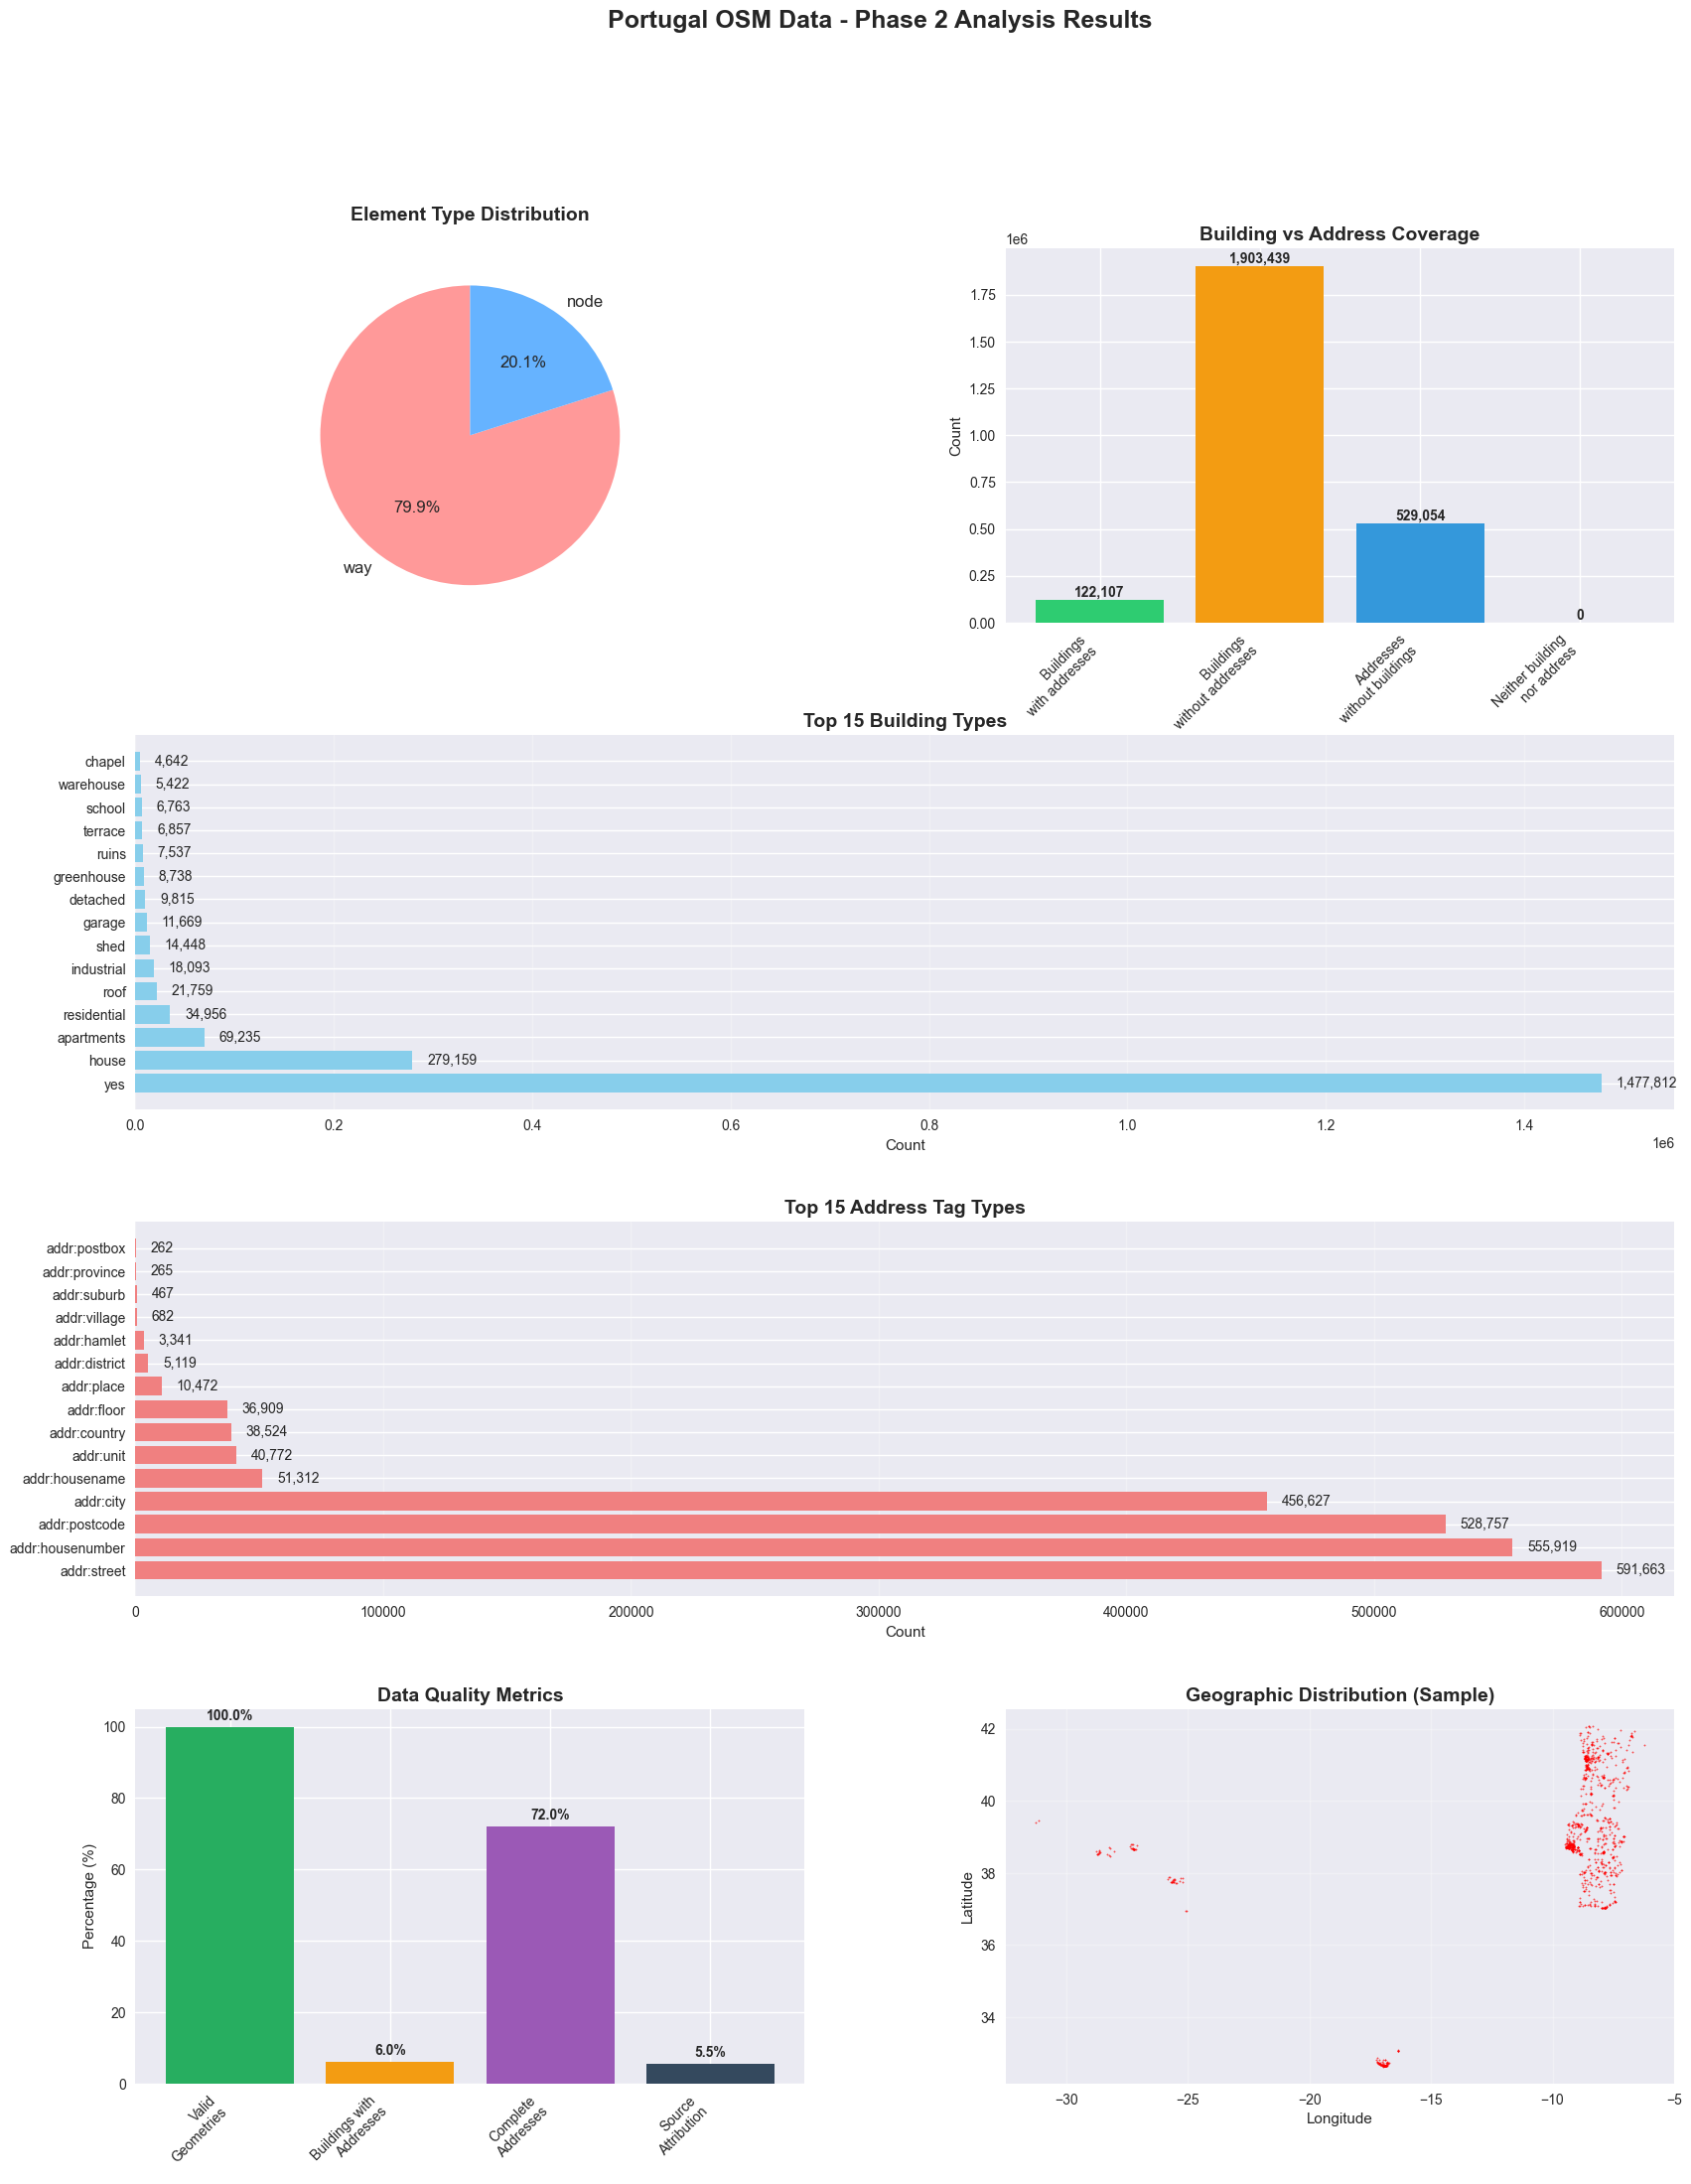

✅ Comprehensive visualization saved as PNG


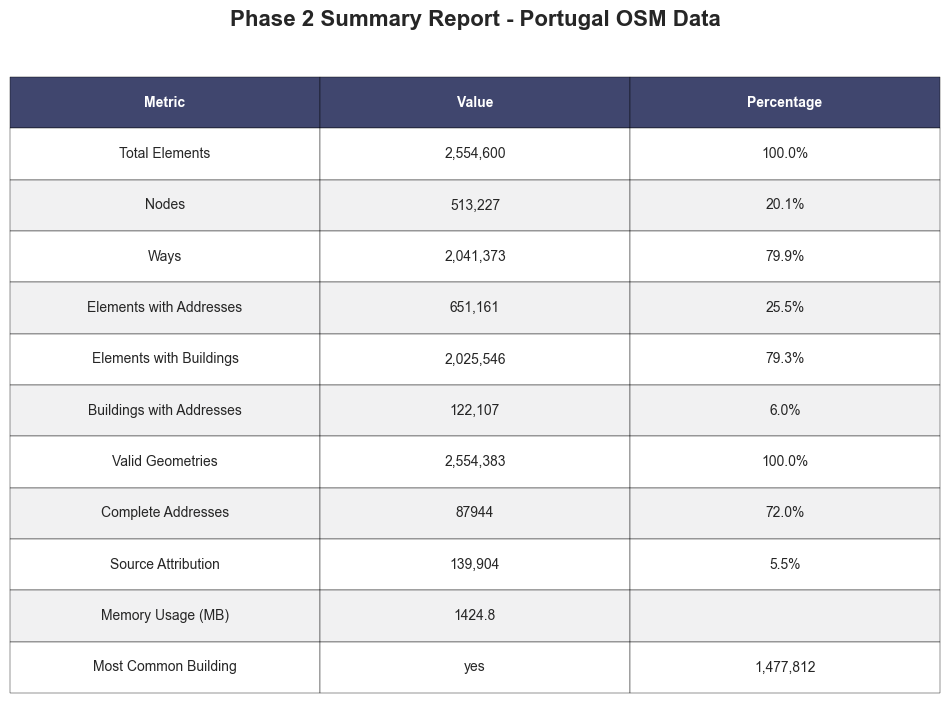

✅ Summary table saved as PNG

📊 EXPORT SUMMARY
Files created in 'phase2_results/':
  📋 summary_statistics.json
  📊 tag_frequency_table.png
  🏠 building_types_table.png
  📮 address_tag_types_table.png
  📊 building_address_matrix_table.png
  📈 dataset_overview_table.png
  🏁 address_completeness_table.png
  🌍 geographic_extent_table.png
  🔍 data_quality_table.png
  🖼️  phase2_comprehensive_analysis.png
  📋 phase2_summary_table.png
  📄 data_sample.csv

✅ All Phase 2 results exported successfully!

📈 STATISTICAL TABLES CREATED:
  • Tag Frequency Analysis (Top 30)
  • Building Types Distribution (Top 20)
  • Address Tag Types Analysis (Top 20)
  • Building vs Address Cross-Tabulation
  • Dataset Overview Statistics
  • Address Completeness Analysis
  • Geographic Distribution Metrics
  • Data Quality Assessment with Ratings


In [15]:
# Create export directory
export_dir = "phase2_results"
os.makedirs(export_dir, exist_ok=True)

print(f"📁 EXPORTING PHASE 2 RESULTS")
print(f"{'='*60}")
print(f"Export directory: {export_dir}/")

# Export Summary Statistics as Structured Data
summary_stats = {
    'dataset_overview': {
        'total_elements': int(total_elements),
        'memory_usage_mb': float(df.memory_usage(deep=True).sum() / 1024**2),
        'element_types': {k: int(v) for k, v in type_counts.items()}
    },
    'address_coverage': {
        'elements_with_addresses': int(elements_with_addresses),
        'elements_with_buildings': int(elements_with_buildings),
        'buildings_with_addresses': int(buildings_with_addresses),
        'address_coverage_percent': float(elements_with_addresses/total_elements*100),
        'building_address_percent': float(buildings_with_addresses/elements_with_buildings*100)
    },
    'data_quality': {
        'valid_geometries': int(valid_geometries.sum()),
        'valid_geometry_percent': float(valid_geometries.sum()/len(df)*100),
        'source_attributed_elements': len(source_tags) if source_tags else 0,
        'complete_addresses': complete_addresses if 'complete_addresses' in locals() else 0,
        'partial_addresses': partial_addresses if 'partial_addresses' in locals() else 0
    },
    'geographic_extent': {
        'longitude_range': [float(min(lons)), float(max(lons))] if coordinates else [None, None],
        'latitude_range': [float(min(lats)), float(max(lats))] if coordinates else [None, None],
        'center_point': [float(np.mean(lons)), float(np.mean(lats))] if coordinates else [None, None],
        'coverage_degrees': [float(lon_span), float(lat_span)] if coordinates else [None, None]
    }
}

with open(f"{export_dir}/summary_statistics.json", 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"✅ Summary statistics saved as JSON")

# Create Statistical Tables as Images
def create_table_image(data, title, filename, figsize=(12, 8)):
    """Create a formatted table image"""
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=data[1:], colLabels=data[0], 
                    cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)
    
    # Style the table
    for i in range(len(data[0])):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    for i in range(1, len(data)):
        for j in range(len(data[0])):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f1f1f2')
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.savefig(f"{export_dir}/{filename}.png", 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()

# 1. Tag Frequency Table
tag_freq_data = [['Rank', 'Tag Key', 'Count', 'Percentage']]
for i, (key, count) in enumerate(tag_key_counts.most_common(30), 1):
    percentage = f"{count/len(df)*100:.1f}%"
    tag_freq_data.append([str(i), key, f"{count:,}", percentage])

create_table_image(tag_freq_data, 'Top 30 Most Common Tag Keys', 'tag_frequency_table')

# 2. Building Types Table
building_types_data = [['Rank', 'Building Type', 'Count', 'Percentage']]
for i, (btype, count) in enumerate(building_counts.most_common(20), 1):
    percentage = f"{count/len(building_tags)*100:.1f}%"
    building_types_data.append([str(i), btype, f"{count:,}", percentage])

create_table_image(building_types_data, 'Top 20 Building Types', 'building_types_table')

# 3. Address Tag Types Table
addr_tag_data = [['Rank', 'Address Tag', 'Count', 'Percentage']]
for i, (tag, count) in enumerate(addr_tag_counts.most_common(20), 1):
    percentage = f"{count/elements_with_addresses*100:.1f}%"
    addr_tag_data.append([str(i), tag, f"{count:,}", percentage])

create_table_image(addr_tag_data, 'Top 20 Address Tag Types', 'address_tag_types_table')

# 4. Building vs Address Matrix Table
matrix_data = [['Category', 'No Address', 'Has Address', 'Total']]
for idx, row in cross_tab.iterrows():
    matrix_data.append([str(idx), f"{row['No Address']:,}", f"{row['Has Address']:,}", f"{row['Total']:,}"])

create_table_image(matrix_data, 'Building vs Address Cross-Tabulation Matrix', 'building_address_matrix_table')

# 5. Dataset Overview Statistics Table
overview_data = [['Metric', 'Value', 'Details']]
overview_data.extend([
    ['Total Elements', f"{total_elements:,}", '100% of dataset'],
    ['Nodes', f"{type_counts.get('node', 0):,}", f"{type_counts.get('node', 0)/total_elements*100:.1f}% of total"],
    ['Ways', f"{type_counts.get('way', 0):,}", f"{type_counts.get('way', 0)/total_elements*100:.1f}% of total"],
    ['Memory Usage', f"{df.memory_usage(deep=True).sum() / 1024**2:.1f} MB", 'RAM footprint'],
    ['Valid Geometries', f"{valid_geometries.sum():,}", f"{valid_geometries.sum()/len(df)*100:.1f}% of elements"],
    ['Elements with Addresses', f"{elements_with_addresses:,}", f"{elements_with_addresses/total_elements*100:.1f}% of total"],
    ['Elements with Buildings', f"{elements_with_buildings:,}", f"{elements_with_buildings/total_elements*100:.1f}% of total"],
    ['Buildings with Addresses', f"{buildings_with_addresses:,}", f"{buildings_with_addresses/elements_with_buildings*100:.1f}% of buildings"]
])

create_table_image(overview_data, 'Dataset Overview Statistics', 'dataset_overview_table')

# 6. Address Completeness Analysis Table
completeness_data = [['Address Component', 'Count', 'Percentage of Addressed Elements']]
if len(addressed_buildings) > 0:
    completeness_data.extend([
        ['Complete Addresses (Street + Number)', f"{complete_addresses:,}", f"{complete_addresses/len(addressed_buildings)*100:.1f}%"],
        ['Partial Addresses (Street OR Number)', f"{partial_addresses:,}", f"{partial_addresses/len(addressed_buildings)*100:.1f}%"],
        ['Total Addressed Buildings', f"{len(addressed_buildings):,}", f"{len(addressed_buildings)/elements_with_buildings*100:.1f}% of buildings"]
    ])
else:
    completeness_data.append(['No addressed buildings found', '-', '-'])

create_table_image(completeness_data, 'Address Completeness Analysis', 'address_completeness_table')

# 7. Geographic Extent Table
if coordinates:
    geo_data = [['Geographic Metric', 'Value', 'Description']]
    geo_data.extend([
        ['Longitude Range', f"{min(lons):.6f} to {max(lons):.6f}", 'West to East bounds'],
        ['Latitude Range', f"{min(lats):.6f} to {max(lats):.6f}", 'South to North bounds'],
        ['Center Point', f"({np.mean(lons):.6f}, {np.mean(lats):.6f})", 'Geographic center'],
        ['Coverage Area', f"{lon_span:.3f}° × {lat_span:.3f}°", 'Longitude × Latitude span'],
        ['Grid Cells with Data', f"{len(grid_counts)}/100", 'Populated 10×10 grid cells'],
        ['Max Elements per Cell', f"{max(grid_counts):,}", 'Highest density area'],
        ['Avg Elements per Cell', f"{np.mean(grid_counts):.0f}", 'Average density']
    ])
    
    create_table_image(geo_data, 'Geographic Distribution Analysis', 'geographic_extent_table')

# 8. Data Quality Assessment Table
quality_data = [['Quality Metric', 'Count', 'Percentage', 'Assessment']]
quality_data.extend([
    ['Valid Geometries', f"{valid_geometries.sum():,}", f"{valid_geometries.sum()/len(df)*100:.1f}%", 
     '✅ Excellent' if valid_geometries.sum()/len(df) > 0.95 else '✅ Good' if valid_geometries.sum()/len(df) > 0.8 else '⚠️ Needs attention'],
    ['Source Attribution', f"{len(source_tags) if source_tags else 0:,}", f"{len(source_tags)/len(df)*100:.1f}%" if source_tags else '0.0%',
     '✅ Good' if source_tags and len(source_tags)/len(df) > 0.1 else '⚠️ Limited'],
    ['Building Address Coverage', f"{buildings_with_addresses:,}", f"{buildings_with_addresses/elements_with_buildings*100:.1f}%",
     '✅ Good' if buildings_with_addresses/elements_with_buildings > 0.5 else '⚠️ Low coverage'],
    ['Complete Addresses', f"{complete_addresses if 'complete_addresses' in locals() else 0:,}", 
     f"{complete_addresses/len(addressed_buildings)*100:.1f}%" if 'complete_addresses' in locals() and len(addressed_buildings) > 0 else 'N/A',
     '✅ Good' if 'complete_addresses' in locals() and len(addressed_buildings) > 0 and complete_addresses/len(addressed_buildings) > 0.7 else '⚠️ Incomplete']
])

create_table_image(quality_data, 'Data Quality Assessment', 'data_quality_table')

print(f"✅ Statistical tables exported as image files")

# Create Enhanced Visualizations for Export
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 24))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# Element Type Distribution (Enhanced Pie Chart)
ax1 = fig.add_subplot(gs[0, 0])
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
wedges, texts, autotexts = ax1.pie(type_counts.values, labels=type_counts.index, 
                                   autopct='%1.1f%%', startangle=90, colors=colors,
                                   textprops={'fontsize': 12})
ax1.set_title('Element Type Distribution', fontsize=14, fontweight='bold', pad=20)

# Building vs Address Coverage (Enhanced Bar Chart)
ax2 = fig.add_subplot(gs[0, 1])
coverage_data = {
    'Buildings\nwith addresses': buildings_with_addresses,
    'Buildings\nwithout addresses': elements_with_buildings - buildings_with_addresses,
    'Addresses\nwithout buildings': elements_with_addresses - buildings_with_addresses,
    'Neither building\nnor address': total_elements - elements_with_buildings - elements_with_addresses + buildings_with_addresses
}
bars = ax2.bar(range(len(coverage_data)), list(coverage_data.values()), 
               color=['#2ecc71', '#f39c12', '#3498db', '#e74c3c'])
ax2.set_xticks(range(len(coverage_data)))
ax2.set_xticklabels(list(coverage_data.keys()), rotation=45, ha='right')
ax2.set_title('Building vs Address Coverage', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count')
for i, v in enumerate(coverage_data.values()):
    ax2.text(i, v + max(coverage_data.values())*0.01, f'{v:,}', ha='center', fontweight='bold')

# Top Building Types (Horizontal Bar Chart)
ax3 = fig.add_subplot(gs[1, :])
if building_counts:
    top_15_buildings = dict(building_counts.most_common(15))
    y_pos = range(len(top_15_buildings))
    bars = ax3.barh(y_pos, list(top_15_buildings.values()), color='skyblue')
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(list(top_15_buildings.keys()))
    ax3.set_xlabel('Count')
    ax3.set_title('Top 15 Building Types', fontsize=14, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    for i, v in enumerate(top_15_buildings.values()):
        ax3.text(v + max(top_15_buildings.values())*0.01, i, f'{v:,}', va='center')

# Address Tag Types (Horizontal Bar Chart)
ax4 = fig.add_subplot(gs[2, :])
if addr_tag_counts:
    top_15_addr = dict(addr_tag_counts.most_common(15))
    y_pos = range(len(top_15_addr))
    bars = ax4.barh(y_pos, list(top_15_addr.values()), color='lightcoral')
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(list(top_15_addr.keys()))
    ax4.set_xlabel('Count')
    ax4.set_title('Top 15 Address Tag Types', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    for i, v in enumerate(top_15_addr.values()):
        ax4.text(v + max(top_15_addr.values())*0.01, i, f'{v:,}', va='center')

# Data Quality Metrics (Multiple metrics visualization)
ax5 = fig.add_subplot(gs[3, 0])
quality_metrics = {
    'Valid\nGeometries': valid_geometries.sum()/len(df)*100,
    'Buildings with\nAddresses': buildings_with_addresses/elements_with_buildings*100,
    'Complete\nAddresses': (complete_addresses/len(addressed_buildings)*100) if len(addressed_buildings) > 0 else 0,
    'Source\nAttribution': (len(source_tags)/len(df)*100) if source_tags else 0
}
bars = ax5.bar(range(len(quality_metrics)), list(quality_metrics.values()), 
               color=['#27ae60', '#f39c12', '#9b59b6', '#34495e'])
ax5.set_xticks(range(len(quality_metrics)))
ax5.set_xticklabels(list(quality_metrics.keys()), rotation=45, ha='right')
ax5.set_ylabel('Percentage (%)')
ax5.set_title('Data Quality Metrics', fontsize=14, fontweight='bold')
ax5.set_ylim(0, 105)
for i, v in enumerate(quality_metrics.values()):
    ax5.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Geographic Coverage 
ax6 = fig.add_subplot(gs[3, 1])
if coordinates and len(coordinates) > 100:
    # Sample coordinates for visualization (to avoid overplotting)
    sample_coords = coordinates[::max(1, len(coordinates)//1000)]
    sample_lons, sample_lats = zip(*sample_coords)
    scatter = ax6.scatter(sample_lons, sample_lats, alpha=0.6, s=1, c='red')
    ax6.set_xlabel('Longitude')
    ax6.set_ylabel('Latitude')
    ax6.set_title('Geographic Distribution (Sample)', fontsize=14, fontweight='bold')
    ax6.grid(True, alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No geographic data\navailable for plotting', 
             ha='center', va='center', transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Geographic Distribution', fontsize=14, fontweight='bold')

plt.suptitle(f'Portugal OSM Data - Phase 2 Analysis Results\n', 
             fontsize=18, fontweight='bold', y=0.98)

# Save the comprehensive visualization
plt.savefig(f"{export_dir}/phase2_comprehensive_analysis.png", 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ Comprehensive visualization saved as PNG")

# Create Summary Report as Formatted Table Image
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')

# Create summary table data
summary_data = [
    ['Metric', 'Value', 'Percentage'],
    ['Total Elements', f"{total_elements:,}", '100.0%'],
    ['Nodes', f"{type_counts.get('node', 0):,}", f"{type_counts.get('node', 0)/total_elements*100:.1f}%"],
    ['Ways', f"{type_counts.get('way', 0):,}", f"{type_counts.get('way', 0)/total_elements*100:.1f}%"],
    ['Elements with Addresses', f"{elements_with_addresses:,}", f"{elements_with_addresses/total_elements*100:.1f}%"],
    ['Elements with Buildings', f"{elements_with_buildings:,}", f"{elements_with_buildings/total_elements*100:.1f}%"],
    ['Buildings with Addresses', f"{buildings_with_addresses:,}", f"{buildings_with_addresses/elements_with_buildings*100:.1f}%"],
    ['Valid Geometries', f"{valid_geometries.sum():,}", f"{valid_geometries.sum()/len(df)*100:.1f}%"],
    ['Complete Addresses', f"{complete_addresses if 'complete_addresses' in locals() else 'N/A'}", 
     f"{complete_addresses/len(addressed_buildings)*100:.1f}%" if 'complete_addresses' in locals() and len(addressed_buildings) > 0 else 'N/A'],
    ['Source Attribution', f"{len(source_tags) if source_tags else 0:,}", f"{len(source_tags)/len(df)*100:.1f}%" if source_tags else '0.0%'],
    ['Memory Usage (MB)', f"{df.memory_usage(deep=True).sum() / 1024**2:.1f}", ''],
    ['Most Common Building', f"{building_counts.most_common(1)[0][0] if building_counts else 'N/A'}", 
     f"{building_counts.most_common(1)[0][1]:,}" if building_counts else 'N/A']
]

table = ax.table(cellText=summary_data[1:], colLabels=summary_data[0], 
                cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the table
for i in range(len(summary_data[0])):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(summary_data)):
    for j in range(len(summary_data[0])):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f1f1f2')

plt.title(f'Phase 2 Summary Report - Portugal OSM Data\n', 
          fontsize=16, fontweight='bold', pad=20)
plt.savefig(f"{export_dir}/phase2_summary_table.png", 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ Summary table saved as PNG")

# Export raw data sample for reference
sample_data = df.head(100).copy()
sample_data.to_csv(f"{export_dir}/data_sample.csv", index=False)

print(f"\n📊 EXPORT SUMMARY")
print(f"{'='*50}")
print(f"Files created in '{export_dir}/':")
print(f"  📋 summary_statistics.json")
print(f"  📊 tag_frequency_table.png")
print(f"  🏠 building_types_table.png") 
print(f"  📮 address_tag_types_table.png")
print(f"  📊 building_address_matrix_table.png")
print(f"  📈 dataset_overview_table.png")
print(f"  🏁 address_completeness_table.png")
print(f"  🌍 geographic_extent_table.png")
print(f"  🔍 data_quality_table.png")
print(f"  🖼️  phase2_comprehensive_analysis.png")
print(f"  📋 phase2_summary_table.png")
print(f"  📄 data_sample.csv")
print(f"\n✅ All Phase 2 results exported successfully!")
print(f"\n📈 STATISTICAL TABLES CREATED:")
print(f"  • Tag Frequency Analysis (Top 30)")
print(f"  • Building Types Distribution (Top 20)")
print(f"  • Address Tag Types Analysis (Top 20)")
print(f"  • Building vs Address Cross-Tabulation")
print(f"  • Dataset Overview Statistics")
print(f"  • Address Completeness Analysis")
print(f"  • Geographic Distribution Metrics")
print(f"  • Data Quality Assessment with Ratings")

# Phase 3: Micro Analysis - The Address Deep Dive 📮

**Objective:** Quantify and identify exact inconsistencies and completeness issues with address data for future normalization decisions.

This comprehensive analysis phase will provide:
- **Address Completeness Discovery** - Identification of missing essential address components
- **Value Variation Detection** - Street prefixes, postal code formats, city name patterns
- **Structural Pattern Analysis** - Node vs Way mapping distributions
- **Data Quality Issue Identification** - Encoding problems, format inconsistencies
- **Inconsistency Quantification** - Metrics for future standardization decisions
- **Pattern Documentation** - Comprehensive cataloging of data quality issues

**Note:** This phase focuses purely on **analysis and discovery** - no data cleaning or normalization is performed.

In [16]:
# Address Completeness Matrix Analysis
print(f"📮 PHASE 3.1: ADDRESS COMPLETENESS MATRIX")
print(f"{'='*70}")

# Filter only elements with address tags
addressed_elements = df[df['has_address']].copy()
print(f"Analyzing {len(addressed_elements):,} elements with address information...")

# Essential address components to analyze
essential_components = [
    'addr:street',
    'addr:housenumber', 
    'addr:postcode',
    'addr:city',
    'addr:country'
]

# Additional useful components
useful_components = [
    'addr:housename',
    'addr:suburb',
    'addr:village',
    'addr:municipality',
    'addr:province',
    'addr:state',
    'addr:district',
    'addr:unit',
    'addr:floor'
]

# completeness matrix
completeness_matrix = pd.DataFrame(index=addressed_elements.index)

for component in essential_components + useful_components:
    completeness_matrix[component] = addressed_elements['parsed_tags'].apply(
        lambda tags: component in tags if isinstance(tags, dict) else False
    )

# completeness statistics
print(f"\n🔍 ESSENTIAL COMPONENTS ANALYSIS")
print(f"{'='*50}")
print(f"{'Component':<20} {'Count':<10} {'Percentage':<12} {'Status'}")
print(f"{'-'*55}")

essential_stats = {}
for component in essential_components:
    count = completeness_matrix[component].sum()
    percentage = (count / len(addressed_elements)) * 100
    status = "✅ Good" if percentage > 70 else "⚠️ Poor" if percentage > 30 else "❌ Critical"
    essential_stats[component] = {'count': count, 'percentage': percentage}
    print(f"{component:<20} {count:<10,} {percentage:<11.1f}% {status}")

# Define address completeness levels
print(f"\n📊 ADDRESS COMPLETENESS LEVELS")
print(f"{'='*50}")

# Basic (Street + Number)
basic_complete = completeness_matrix['addr:street'] & completeness_matrix['addr:housenumber']
basic_count = basic_complete.sum()

# Standard (Street + Number + City)
standard_complete = basic_complete & completeness_matrix['addr:city']
standard_count = standard_complete.sum()

# Full (Street + Number + City + Postcode)
full_complete = standard_complete & completeness_matrix['addr:postcode']
full_count = full_complete.sum()

# Complete (All essential components)
complete_complete = full_complete & completeness_matrix['addr:country']
complete_count = complete_complete.sum()

completeness_levels = {
    'Incomplete (Missing Street or Number)': len(addressed_elements) - basic_count,
    'Basic (Street + Number)': basic_count - standard_count,
    'Standard (+ City)': standard_count - full_count,
    'Full (+ Postcode)': full_count - complete_count,
    'Complete (+ Country)': complete_count
}

print(f"{'Level':<35} {'Count':<10} {'Percentage'}")
print(f"{'-'*55}")
for level, count in completeness_levels.items():
    percentage = (count / len(addressed_elements)) * 100
    print(f"{level:<35} {count:<10,} {percentage:.1f}%")

# Component combination analysis
print(f"\n🔗 COMPONENT COMBINATION PATTERNS")
print(f"{'='*50}")

# Most common combinations
combination_patterns = []
for idx, row in completeness_matrix[essential_components].iterrows():
    pattern = [comp.split(':')[1] for comp, present in row.items() if present]
    combination_patterns.append('+'.join(sorted(pattern)) if pattern else 'none')

pattern_counts = Counter(combination_patterns)
print(f"Top 10 address component combinations:")
for i, (pattern, count) in enumerate(pattern_counts.most_common(10), 1):
    percentage = (count / len(addressed_elements)) * 100
    print(f"{i:2}. {pattern:<30} {count:>6,} ({percentage:4.1f}%)")

# Store completeness data for export
addressed_elements['basic_complete'] = basic_complete
addressed_elements['standard_complete'] = standard_complete
addressed_elements['full_complete'] = full_complete
addressed_elements['complete_complete'] = complete_complete

📮 PHASE 3.1: ADDRESS COMPLETENESS MATRIX
Analyzing 651,161 elements with address information...
Analyzing 651,161 elements with address information...

🔍 ESSENTIAL COMPONENTS ANALYSIS
Component            Count      Percentage   Status
-------------------------------------------------------
addr:street          591,663    90.9       % ✅ Good
addr:housenumber     555,919    85.4       % ✅ Good
addr:postcode        528,757    81.2       % ✅ Good
addr:city            456,627    70.1       % ✅ Good
addr:country         38,524     5.9        % ❌ Critical

📊 ADDRESS COMPLETENESS LEVELS
Level                               Count      Percentage
-------------------------------------------------------
Incomplete (Missing Street or Number) 117,694    18.1%
Basic (Street + Number)             141,587    21.7%
Standard (+ City)                   19,792     3.0%
Full (+ Postcode)                   353,430    54.3%
Complete (+ Country)                18,658     2.9%

🔗 COMPONENT COMBINATION PATTERNS


In [17]:
# Street Name Variation Analysis
print(f"\n🛣️ PHASE 3.2: STREET NAME VARIATION ANALYSIS")
print(f"{'='*70}")

# Extract street names
street_names = []
for tags in addressed_elements['parsed_tags']:
    if isinstance(tags, dict) and 'addr:street' in tags:
        street_names.append(tags['addr:street'])

print(f"Analyzing {len(street_names):,} street names...")

# Portuguese street prefixes and variations
portuguese_prefixes = {
    'Rua': ['Rua', 'R.', 'R', 'RUA'],
    'Avenida': ['Avenida', 'Av.', 'Av', 'Ave', 'AVENIDA'],
    'Largo': ['Largo', 'Lgo.', 'Lgo', 'LARGO'],
    'Praça': ['Praça', 'Pça.', 'Pça', 'Praca', 'PRAÇA'],
    'Travessa': ['Travessa', 'Tv.', 'Tv', 'Trav.', 'TRAVESSA'],
    'Beco': ['Beco', 'Bc.', 'Bc', 'BECO'],
    'Estrada': ['Estrada', 'Est.', 'Est', 'ESTRADA'],
    'Alameda': ['Alameda', 'Al.', 'Al', 'ALAMEDA'],
    'Calçada': ['Calçada', 'Calc.', 'Calc', 'Calcada', 'CALÇADA'],
    'Rotunda': ['Rotunda', 'Rot.', 'Rot', 'ROTUNDA']
}

# Analyze prefix patterns
prefix_analysis = {}
unmatched_streets = []

for street in street_names:
    street_clean = street.strip()
    matched = False
    
    for standard_prefix, variations in portuguese_prefixes.items():
        for variation in variations:
            if street_clean.startswith(variation + ' ') or street_clean == variation:
                if standard_prefix not in prefix_analysis:
                    prefix_analysis[standard_prefix] = {'variations': {}, 'total': 0}
                
                if variation not in prefix_analysis[standard_prefix]['variations']:
                    prefix_analysis[standard_prefix]['variations'][variation] = 0
                
                prefix_analysis[standard_prefix]['variations'][variation] += 1
                prefix_analysis[standard_prefix]['total'] += 1
                matched = True
                break
        if matched:
            break
    
    if not matched and street_clean:
        unmatched_streets.append(street_clean)

print(f"\n📊 STREET PREFIX STANDARDIZATION ANALYSIS")
print(f"{'='*60}")
print(f"{'Standard Prefix':<15} {'Total':<8} {'Variations':<12} {'Most Common'}")
print(f"{'-'*60}")

standardization_opportunities = 0
for prefix, data in sorted(prefix_analysis.items(), key=lambda x: x[1]['total'], reverse=True):
    variations = data['variations']
    most_common = max(variations, key=variations.get)
    variation_count = len(variations)
    
    if variation_count > 1:
        standardization_opportunities += sum(count for var, count in variations.items() if var != most_common)
    
    print(f"{prefix:<15} {data['total']:<8,} {variation_count:<12} {most_common}")

print(f"\n🎯 STANDARDIZATION OPPORTUNITIES")
print(f"{'='*50}")
print(f"Streets needing prefix standardization: {standardization_opportunities:,}")
print(f"Percentage of streets: {standardization_opportunities/len(street_names)*100:.1f}%")

# Detailed variation analysis
print(f"\n🔍 DETAILED PREFIX VARIATIONS")
print(f"{'='*50}")
for prefix, data in prefix_analysis.items():
    if len(data['variations']) > 1:
        print(f"\n{prefix}:")
        for variation, count in sorted(data['variations'].items(), key=lambda x: x[1], reverse=True):
            percentage = (count / data['total']) * 100
            print(f"  {variation:<15} {count:>6,} ({percentage:4.1f}%)")

# Analyze unmatched streets for patterns
print(f"\n❓ UNMATCHED STREET PATTERNS")
print(f"{'='*50}")
print(f"Streets without recognized prefixes: {len(unmatched_streets):,} ({len(unmatched_streets)/len(street_names)*100:.1f}%)")

if unmatched_streets:
    # Look for common patterns in unmatched streets
    unmatched_first_words = [street.split()[0] if street.split() else '' for street in unmatched_streets[:1000]]
    unmatched_counter = Counter(unmatched_first_words)
    
    print(f"\nTop 15 unrecognized first words (sample of first 1000):")
    for i, (word, count) in enumerate(unmatched_counter.most_common(15), 1):
        if word:  # Skip empty strings
            print(f"{i:2}. {word:<20} {count:>4} occurrences")

# Case analysis
print(f"\n📝 CASE ANALYSIS")
print(f"{'='*50}")
case_patterns = {'UPPER': 0, 'lower': 0, 'Title': 0, 'Mixed': 0}

for street in street_names[:1000]:  
    if street.isupper():
        case_patterns['UPPER'] += 1
    elif street.islower():
        case_patterns['lower'] += 1
    elif street.istitle():
        case_patterns['Title'] += 1
    else:
        case_patterns['Mixed'] += 1

print("Case distribution (sample of 1000 streets):")
for case_type, count in case_patterns.items():
    percentage = (count / 1000) * 100
    print(f"{case_type:<10} {count:>4} ({percentage:4.1f}%)")


🛣️ PHASE 3.2: STREET NAME VARIATION ANALYSIS
Analyzing 591,663 street names...

📊 STREET PREFIX STANDARDIZATION ANALYSIS
Standard Prefix Total    Variations   Most Common
------------------------------------------------------------
Rua             411,502  4            Rua
Avenida         33,301   4            Avenida
Estrada         29,907   3            Estrada
Travessa        23,449   4            Travessa
Largo           13,065   2            Largo
Beco            5,477    2            Beco
Praça           4,929    2            Praça
Calçada         1,722    2            Calçada
Alameda         1,450    2            Alameda
Rotunda         102      1            Rotunda

🎯 STANDARDIZATION OPPORTUNITIES
Streets needing prefix standardization: 11,287
Percentage of streets: 1.9%

🔍 DETAILED PREFIX VARIATIONS

Largo:
  Largo           13,064 (100.0%)
  LARGO                1 ( 0.0%)

Avenida:
  Avenida         32,348 (97.1%)
  Av                 604 ( 1.8%)
  Av.                347 ( 1

In [18]:
# Postal Code Format Analysis
print(f"\n📮 PHASE 3.3: POSTAL CODE FORMAT ANALYSIS")
print(f"{'='*70}")

# Extract postal codes
postal_codes = []
for tags in addressed_elements['parsed_tags']:
    if isinstance(tags, dict) and 'addr:postcode' in tags:
        postal_codes.append(tags['addr:postcode'])

print(f"Analyzing {len(postal_codes):,} postal codes...")

# Portuguese postal code format: XXXX-XXX
import re

# Define format patterns
patterns = {
    'Standard (XXXX-XXX)': r'^\d{4}-\d{3}$',
    'No Dash (XXXXXXX)': r'^\d{7}$',
    'Partial (XXXX)': r'^\d{4}$',
    'With Spaces': r'^\d{4}\s+\d{3}$',
    'Extra Digits': r'^\d{4}-\d{4,}$',
    'Invalid Format': None  
}

format_analysis = {pattern: [] for pattern in patterns.keys()}
format_counts = {pattern: 0 for pattern in patterns.keys()}

for postcode in postal_codes:
    postcode_clean = postcode.strip()
    matched = False
    
    for pattern_name, pattern_regex in patterns.items():
        if pattern_regex and re.match(pattern_regex, postcode_clean):
            format_analysis[pattern_name].append(postcode_clean)
            format_counts[pattern_name] += 1
            matched = True
            break
    
    if not matched:
        format_analysis['Invalid Format'].append(postcode_clean)
        format_counts['Invalid Format'] += 1

print(f"\n📊 POSTAL CODE FORMAT DISTRIBUTION")
print(f"{'='*50}")
print(f"{'Format':<20} {'Count':<10} {'Percentage':<12} {'Status'}")
print(f"{'-'*55}")

total_postcodes = len(postal_codes)
for format_name, count in format_counts.items():
    percentage = (count / total_postcodes) * 100
    if format_name == 'Standard (XXXX-XXX)':
        status = "✅ Correct"
    elif count > 0:
        status = "⚠️ Needs Fix"
    else:
        status = "✅ None"
    
    print(f"{format_name:<20} {count:<10,} {percentage:<11.1f}% {status}")

# Detailed analysis of non-standard formats
print(f"\n🔍 DETAILED NON-STANDARD ANALYSIS")
print(f"{'='*50}")

standardization_needed = total_postcodes - format_counts['Standard (XXXX-XXX)']
print(f"Postal codes needing standardization: {standardization_needed:,} ({standardization_needed/total_postcodes*100:.1f}%)")

# Show examples of each format
for format_name, examples in format_analysis.items():
    if examples and format_name != 'Standard (XXXX-XXX)':
        print(f"\n{format_name} examples (showing up to 10):")
        unique_examples = list(set(examples))[:10]
        for example in unique_examples:
            print(f"  '{example}'")

# Postal code geographic distribution (first 4 digits analysis)
print(f"\n🗺️ GEOGRAPHIC DISTRIBUTION (First 4 Digits)")
print(f"{'='*50}")

valid_postcodes = format_analysis['Standard (XXXX-XXX)'] + format_analysis['No Dash (XXXXXXX)']
first_four_digits = []

for postcode in valid_postcodes:
    # Extract first 4 digits regardless of format
    digits_only = re.sub(r'\D', '', postcode)
    if len(digits_only) >= 4:
        first_four_digits.append(digits_only[:4])

if first_four_digits:
    geographic_distribution = Counter(first_four_digits)
    print(f"Unique postal areas: {len(geographic_distribution)}")
    print(f"\nTop 15 postal areas by frequency:")
    for i, (area, count) in enumerate(geographic_distribution.most_common(15), 1):
        percentage = (count / len(first_four_digits)) * 100
        # Try to identify major cities by postal code
        city_info = ""
        if area.startswith('10') or area.startswith('11') or area.startswith('12'):
            city_info = "(Lisbon area)"
        elif area.startswith('40') or area.startswith('41') or area.startswith('42'):
            city_info = "(Porto area)"
        elif area.startswith('30'):
            city_info = "(Coimbra area)"
            
        print(f"{i:2}. {area} {city_info:<15} {count:>6,} ({percentage:4.1f}%)")

# Validation rules for postal codes
print(f"\n✅ POSTAL CODE VALIDATION RULES")
print(f"{'='*50}")
print("Portuguese postal code standards:")
print("• Format: XXXX-XXX (4 digits, dash, 3 digits)")
print("• Range: 1000-000 to 9999-999")
print("• Major areas: 1xxx (Lisbon), 4xxx (Porto), 3xxx (Central)")

# Check for out-of-range postal codes
out_of_range = []
for postcode in format_analysis['Standard (XXXX-XXX)']:
    first_four = int(postcode[:4])
    if first_four < 1000 or first_four > 9999:
        out_of_range.append(postcode)

if out_of_range:
    print(f"\n⚠️ Out-of-range postal codes found: {len(out_of_range)}")
    print("Examples:", out_of_range[:5])
else:
    print(f"\n✅ All standard format postal codes are in valid range")


📮 PHASE 3.3: POSTAL CODE FORMAT ANALYSIS
Analyzing 528,757 postal codes...

📊 POSTAL CODE FORMAT DISTRIBUTION
Format               Count      Percentage   Status
-------------------------------------------------------
Standard (XXXX-XXX)  520,411    98.4       % ✅ Correct
No Dash (XXXXXXX)    24         0.0        % ⚠️ Needs Fix
Partial (XXXX)       6,250      1.2        % ⚠️ Needs Fix
With Spaces          60         0.0        % ⚠️ Needs Fix
Extra Digits         17         0.0        % ⚠️ Needs Fix
Invalid Format       1,995      0.4        % ⚠️ Needs Fix

🔍 DETAILED NON-STANDARD ANALYSIS
Postal codes needing standardization: 8,346 (1.6%)

No Dash (XXXXXXX) examples (showing up to 10):
  '4490523'
  '4740033'
  '2620288'
  '2495402'
  '2450076'
  '4490013'
  '1500437'
  '4000478'
  '1990221'
  '3400645'

Partial (XXXX) examples (showing up to 10):
  '7320'
  '3500'
  '9000'
  '2840'
  '7940'
  '8375'
  '4930'
  '1250'
  '4920'
  '2410'

With Spaces examples (showing up to 10):
  '295

In [19]:
# City Name Variation Analysis
print(f"\n🏙️ PHASE 3.4: CITY NAME VARIATION ANALYSIS")
print(f"{'='*70}")

# Extract city names
city_names = []
for tags in addressed_elements['parsed_tags']:
    if isinstance(tags, dict) and 'addr:city' in tags:
        city_names.append(tags['addr:city'])

print(f"Analyzing {len(city_names):,} city names...")

# Analyze city name patterns
city_counter = Counter(city_names)
unique_cities = len(city_counter)

print(f"\n📊 CITY NAME STATISTICS")
print(f"{'='*50}")
print(f"Unique city names: {unique_cities:,}")
print(f"Total city references: {len(city_names):,}")
print(f"Average references per city: {len(city_names)/unique_cities:.1f}")

# Top cities
print(f"\n🏆 TOP 20 MOST REFERENCED CITIES")
print(f"{'='*50}")
print(f"{'Rank':<4} {'City':<25} {'Count':<10} {'Percentage'}")
print(f"{'-'*50}")

for i, (city, count) in enumerate(city_counter.most_common(20), 1):
    percentage = (count / len(city_names)) * 100
    print(f"{i:<4} {city:<25} {count:<10,} {percentage:.1f}%")

# Detect potential variations and misspellings
print(f"\n🔍 POTENTIAL CITY NAME VARIATIONS")
print(f"{'='*50}")

# Group similar city names using different techniques
from difflib import SequenceMatcher

def similarity(a, b):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

# Find cities with similar names (potential duplicates)
similar_groups = {}
processed_cities = set()

for city1, count1 in city_counter.most_common(200): 
    if city1 in processed_cities:
        continue
        
    group = [city1]
    for city2, count2 in city_counter.items():
        if city2 != city1 and city2 not in processed_cities:
            sim = similarity(city1, city2)
            if sim > 0.85:  
                group.append(city2)
    
    if len(group) > 1:
        similar_groups[city1] = group
        processed_cities.update(group)

if similar_groups:
    print("Potential city name variations detected:")
    for main_city, variations in similar_groups.items():
        total_count = sum(city_counter[city] for city in variations)
        print(f"\n{main_city} group (total: {total_count:,} references):")
        for variant in sorted(variations, key=lambda x: city_counter[x], reverse=True):
            print(f"  {variant:<25} {city_counter[variant]:>6,}")
else:
    print("No obvious city name variations detected with high similarity.")

# Case consistency analysis
print(f"\n📝 CITY NAME CASE ANALYSIS")
print(f"{'='*50}")

case_issues = {'all_upper': 0, 'all_lower': 0, 'mixed_case': 0, 'proper_case': 0}
sample_cities = list(city_counter.keys())[:1000] 

for city in sample_cities:
    if city.isupper():
        case_issues['all_upper'] += 1
    elif city.islower():
        case_issues['all_lower'] += 1
    elif city.istitle():
        case_issues['proper_case'] += 1
    else:
        case_issues['mixed_case'] += 1

print("Case distribution (sample of 1000 cities):")
for case_type, count in case_issues.items():
    percentage = (count / 1000) * 100
    print(f"{case_type.replace('_', ' ').title():<15} {count:>4} ({percentage:4.1f}%)")

# Special character analysis
print(f"\n🔤 SPECIAL CHARACTERS IN CITY NAMES")
print(f"{'='*50}")

special_chars = {}
cities_with_accents = 0
cities_with_hyphens = 0

for city in sample_cities:
    if any(char in city for char in 'áàâãéèêíìîóòôõúùûç'):
        cities_with_accents += 1
    if '-' in city:
        cities_with_hyphens += 1
    
    for char in city:
        if not char.isalnum() and char != ' ' and char != '-':
            special_chars[char] = special_chars.get(char, 0) + 1

print(f"Cities with Portuguese accents: {cities_with_accents} ({cities_with_accents/1000*100:.1f}%)")
print(f"Cities with hyphens: {cities_with_hyphens} ({cities_with_hyphens/1000*100:.1f}%)")

if special_chars:
    print(f"\nOther special characters found:")
    for char, count in sorted(special_chars.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  '{char}': {count} occurrences")

# Administrative hierarchy analysis
print(f"\n🏛️ ADMINISTRATIVE HIERARCHY ANALYSIS")
print(f"{'='*50}")

# Check for administrative levels in different address fields
admin_fields = ['addr:city', 'addr:village', 'addr:municipality', 'addr:suburb', 'addr:province', 'addr:district']
admin_analysis = {}

for field in admin_fields:
    values = []
    for tags in addressed_elements['parsed_tags']:
        if isinstance(tags, dict) and field in tags:
            values.append(tags[field])
    
    admin_analysis[field] = {
        'count': len(values),
        'unique': len(set(values)),
        'top_values': Counter(values).most_common(5) if values else []
    }

print("Administrative field usage:")
for field, data in admin_analysis.items():
    if data['count'] > 0:
        print(f"\n{field}:")
        print(f"  Usage: {data['count']:,} elements ({data['count']/len(addressed_elements)*100:.1f}%)")
        print(f"  Unique values: {data['unique']:,}")
        print(f"  Top values: {', '.join([f'{val} ({cnt})' for val, cnt in data['top_values'][:3]])}")

# Portuguese city name validation
print(f"\n✅ PORTUGUESE CITY VALIDATION OPPORTUNITIES")
print(f"{'='*50}")

# Major Portuguese cities for reference
major_portuguese_cities = {
    'Lisboa', 'Porto', 'Coimbra', 'Braga', 'Aveiro', 'Faro', 'Setúbal', 'Leiria',
    'Viseu', 'Évora', 'Santarém', 'Bragança', 'Guarda', 'Viana do Castelo',
    'Vila Real', 'Portalegre', 'Castelo Branco', 'Beja'
}

# Check if major cities appear in our data
found_major_cities = []
for city in major_portuguese_cities:
    if city in city_counter:
        found_major_cities.append((city, city_counter[city]))

found_major_cities.sort(key=lambda x: x[1], reverse=True)

print(f"Major Portuguese cities found in data:")
for city, count in found_major_cities:
    percentage = (count / len(city_names)) * 100
    print(f"  {city:<20} {count:>6,} ({percentage:4.1f}%)")

print(f"\nTotal elements in major cities: {sum(count for _, count in found_major_cities):,}")
print(f"Percentage of addressed elements: {sum(count for _, count in found_major_cities)/len(city_names)*100:.1f}%")


🏙️ PHASE 3.4: CITY NAME VARIATION ANALYSIS
Analyzing 456,627 city names...

📊 CITY NAME STATISTICS
Unique city names: 4,792
Total city references: 456,627
Average references per city: 95.3

🏆 TOP 20 MOST REFERENCED CITIES
Rank City                      Count      Percentage
--------------------------------------------------
1    Évora                     16,069     3.5%
2    Lisboa                    13,979     3.1%
3    Câmara de Lobos           12,543     2.7%
4    Coimbra                   11,865     2.6%
5    Funchal                   8,266      1.8%
6    Setúbal                   8,162      1.8%
7    Olhão                     7,483      1.6%
8    Almeirim                  6,572      1.4%
9    Calheta                   5,752      1.3%
10   Elvas                     4,686      1.0%
11   Tavira                    4,603      1.0%
12   Vila Real                 4,507      1.0%
13   Peniche                   4,474      1.0%
14   São João da Madeira       3,828      0.8%
15   Moura     

In [20]:
# Structural Analysis - Node vs Way Mapping
print(f"\n🏗️ PHASE 3.5: STRUCTURAL ANALYSIS")
print(f"{'='*70}")

# Analyze element types for addressed elements
element_type_analysis = addressed_elements['type'].value_counts()

print(f"📊 ADDRESS MAPPING BY ELEMENT TYPE")
print(f"{'='*50}")
print(f"{'Element Type':<15} {'Count':<10} {'Percentage':<12} {'Implication'}")
print(f"{'-'*60}")

for elem_type, count in element_type_analysis.items():
    percentage = (count / len(addressed_elements)) * 100
    if elem_type == 'node':
        implication = "Point addresses"
    elif elem_type == 'way':
        implication = "Building/area addresses"
    else:
        implication = "Other geometry"
    
    print(f"{elem_type.capitalize():<15} {count:<10,} {percentage:<11.1f}% {implication}")

# Completeness by element type
print(f"\n🎯 ADDRESS COMPLETENESS BY ELEMENT TYPE")
print(f"{'='*50}")

for elem_type in element_type_analysis.index:
    type_subset = addressed_elements[addressed_elements['type'] == elem_type]
    
    print(f"\n{elem_type.upper()} ELEMENTS ({len(type_subset):,} total):")
    
    # Calculate completeness levels for this type
    basic = type_subset['basic_complete'].sum()
    standard = type_subset['standard_complete'].sum()
    full = type_subset['full_complete'].sum()
    complete = type_subset['complete_complete'].sum()
    
    print(f"  Basic (Street+Number):     {basic:>6,} ({basic/len(type_subset)*100:4.1f}%)")
    print(f"  Standard (+City):          {standard:>6,} ({standard/len(type_subset)*100:4.1f}%)")
    print(f"  Full (+Postcode):          {full:>6,} ({full/len(type_subset)*100:4.1f}%)")
    print(f"  Complete (+Country):       {complete:>6,} ({complete/len(type_subset)*100:4.1f}%)")

# House Number Analysis
print(f"\n🔢 PHASE 3.6: HOUSE NUMBER ANALYSIS")
print(f"{'='*70}")

# Extract house numbers
house_numbers = []
for tags in addressed_elements['parsed_tags']:
    if isinstance(tags, dict) and 'addr:housenumber' in tags:
        house_numbers.append(tags['addr:housenumber'])

print(f"Analyzing {len(house_numbers):,} house numbers...")

# House number format patterns
number_patterns = {
    'Simple Number': r'^\d+$',
    'Number with Letter': r'^\d+[A-Za-z]$',
    'Range (1-3)': r'^\d+-\d+$',
    'Complex (1A-1B)': r'^\d+[A-Za-z]-\d+[A-Za-z]$',
    'Fraction (1/2)': r'^\d+/\d+$',
    'Multiple (1,3,5)': r'^\d+(,\s*\d+)+$',
    'Floor/Unit': r'.*[Ff]loor.*|.*[Uu]nit.*|.*[Aa]ndar.*',
    'Other Format': None
}

number_format_analysis = {pattern: [] for pattern in number_patterns.keys()}
number_format_counts = {pattern: 0 for pattern in number_patterns.keys()}

for number in house_numbers:
    number_clean = number.strip()
    matched = False
    
    for pattern_name, pattern_regex in number_patterns.items():
        if pattern_regex and re.match(pattern_regex, number_clean):
            number_format_analysis[pattern_name].append(number_clean)
            number_format_counts[pattern_name] += 1
            matched = True
            break
    
    if not matched:
        number_format_analysis['Other Format'].append(number_clean)
        number_format_counts['Other Format'] += 1

print(f"\n📊 HOUSE NUMBER FORMAT DISTRIBUTION")
print(f"{'='*50}")
for format_name, count in number_format_counts.items():
    if count > 0:
        percentage = (count / len(house_numbers)) * 100
        print(f"{format_name:<20} {count:<10,} {percentage:.1f}%")

# Show examples of non-standard formats
print(f"\n🔍 NON-STANDARD HOUSE NUMBER EXAMPLES")
print(f"{'='*50}")
for format_name, examples in number_format_analysis.items():
    if examples and format_name not in ['Simple Number', 'Number with Letter']:
        unique_examples = list(set(examples))[:5]
        print(f"{format_name}: {', '.join(unique_examples)}")

# Data Quality Deep Dive
print(f"\n🔍 PHASE 3.7: DATA QUALITY DEEP DIVE")
print(f"{'='*70}")

# Encoding issues detection
print(f"📝 ENCODING AND CHARACTER ISSUES")
print(f"{'='*50}")

encoding_issues = 0
suspicious_chars = 0
empty_values = 0

# Check various address fields for quality issues
quality_fields = ['addr:street', 'addr:city', 'addr:housenumber']

for field in quality_fields:
    field_issues = {'encoding': 0, 'suspicious': 0, 'empty': 0, 'total': 0}
    
    for tags in addressed_elements['parsed_tags']:
        if isinstance(tags, dict) and field in tags:
            value = tags[field]
            field_issues['total'] += 1
            
            if not value or value.strip() == '':
                field_issues['empty'] += 1
            elif any(ord(char) > 127 and char not in 'áàâãéèêíìîóòôõúùûçÁÀÂÃÉÈÊÍÌÎÓÒÔÕÚÙÛÇ' for char in value):
                field_issues['encoding'] += 1
            elif any(char in value for char in ['�', '?', 'NULL', 'null']):
                field_issues['suspicious'] += 1
    
    if field_issues['total'] > 0:
        print(f"\n{field}:")
        print(f"  Total values: {field_issues['total']:,}")
        print(f"  Empty/whitespace: {field_issues['empty']:,} ({field_issues['empty']/field_issues['total']*100:.1f}%)")
        print(f"  Encoding issues: {field_issues['encoding']:,} ({field_issues['encoding']/field_issues['total']*100:.1f}%)")
        print(f"  Suspicious content: {field_issues['suspicious']:,} ({field_issues['suspicious']/field_issues['total']*100:.1f}%)")

# Address consistency cross-validation
print(f"\n🔗 ADDRESS COMPONENT CONSISTENCY")
print(f"{'='*50}")

# Check for postal code-city consistency (sample analysis)
postcode_city_pairs = []
for tags in addressed_elements['parsed_tags'].head(1000):  # Sample for performance
    if isinstance(tags, dict):
        postcode = tags.get('addr:postcode', '')
        city = tags.get('addr:city', '')
        if postcode and city and re.match(r'^\d{4}-\d{3}$', postcode):
            postcode_city_pairs.append((postcode[:2], city))  # First 2 digits + city

if postcode_city_pairs:
    # Group by postcode prefix to find inconsistencies
    postcode_groups = {}
    for prefix, city in postcode_city_pairs:
        if prefix not in postcode_groups:
            postcode_groups[prefix] = []
        postcode_groups[prefix].append(city)
    
    inconsistent_areas = 0
    for prefix, cities in postcode_groups.items():
        unique_cities = set(cities)
        if len(unique_cities) > 1:
            inconsistent_areas += 1
    
    print(f"Postal code areas analyzed: {len(postcode_groups)}")
    print(f"Areas with multiple cities: {inconsistent_areas}")
    if inconsistent_areas > 0:
        print(f"Potential postal code-city inconsistencies: {inconsistent_areas/len(postcode_groups)*100:.1f}%")

# Data Quality Assessment Summary
print(f"\n📊 PHASE 3.8: DATA QUALITY ASSESSMENT SUMMARY")
print(f"{'='*70}")

print(f"🔍 IDENTIFIED STANDARDIZATION OPPORTUNITIES")
print(f"{'='*50}")

print("STREET PREFIX VARIATIONS DETECTED:")
variation_count = 0
for standard_prefix, data in prefix_analysis.items():
    if len(data['variations']) > 1:
        variation_count += len(data['variations']) - 1
        variations = list(data['variations'].keys())
        most_common = max(data['variations'], key=data['variations'].get)
        others = [v for v in variations if v != most_common]
        print(f"  {standard_prefix}: '{most_common}' (standard) + {len(others)} variations: {', '.join(others)}")

print(f"\nPOSTAL CODE FORMAT ISSUES IDENTIFIED:")
non_standard_formats = sum(count for fmt, count in format_counts.items() if fmt != 'Standard (XXXX-XXX)')
print(f"  Total non-standard postal codes: {non_standard_formats:,}")
for fmt, count in format_counts.items():
    if fmt != 'Standard (XXXX-XXX)' and count > 0:
        print(f"  {fmt}: {count:,} cases")

print(f"\nCITY NAME INCONSISTENCIES DETECTED:")
if similar_groups:
    print(f"  Potential duplicate city groups: {len(similar_groups)}")
    for main_city, variations in list(similar_groups.items())[:3]:  # Show first 3
        print(f"  '{main_city}' group: {len(variations)} variations")
else:
    print(f"  No obvious city name duplications detected")

print(f"\nHOUSE NUMBER FORMAT PATTERNS:")
complex_formats = sum(count for fmt, count in number_format_counts.items() if fmt not in ['Simple Number', 'Number with Letter'])
print(f"  Simple numeric: {number_format_counts.get('Simple Number', 0):,}")
print(f"  Complex formats: {complex_formats:,} (ranges, fractions, etc.)")

print(f"\n📊 PHASE 3 ANALYSIS SUMMARY")
print(f"{'='*70}")
print(f"🔍 DISCOVERY RESULTS:")
print(f"  Elements with addresses analyzed: {len(addressed_elements):,}")
print(f"  Complete addresses found: {complete_count:,} ({complete_count/len(addressed_elements)*100:.1f}%)")
print(f"  Street prefix variations detected: {variation_count:,}")
print(f"  Postal code format issues: {standardization_needed:,}")
print(f"  Potential city name groups: {len(similar_groups) if similar_groups else 0}")
print(f"  Complex house number formats: {complex_formats:,}")

print(f"\n🎯 KEY FINDINGS FOR FUTURE PROCESSING:")
print(f"  • Address completeness varies significantly by element type")
print(f"  • Street prefixes show {variation_count} standardization opportunities")
print(f"  • {standardization_needed/len(postal_codes)*100:.1f}% of postal codes need format correction")
print(f"  • City names show potential for similarity-based grouping")
print(f"  • House numbers use diverse formats requiring pattern-based handling")

print(f"\n✅ Phase 3 Complete: Micro-level patterns identified and quantified")
print(f"🎯 Ready for decision-making on normalization and validation strategies")


🏗️ PHASE 3.5: STRUCTURAL ANALYSIS
📊 ADDRESS MAPPING BY ELEMENT TYPE
Element Type    Count      Percentage   Implication
------------------------------------------------------------
Node            512,356    78.7       % Point addresses
Way             138,805    21.3       % Building/area addresses

🎯 ADDRESS COMPLETENESS BY ELEMENT TYPE

NODE ELEMENTS (512,356 total):
  Basic (Street+Number):     440,818 (86.0%)
  Standard (+City):          333,577 (65.1%)
  Full (+Postcode):          320,663 (62.6%)
  Complete (+Country):        8,858 ( 1.7%)

WAY ELEMENTS (138,805 total):
  Basic (Street+Number):     92,649 (66.7%)
  Standard (+City):          58,303 (42.0%)
  Full (+Postcode):          51,425 (37.0%)
  Complete (+Country):        9,800 ( 7.1%)

🔢 PHASE 3.6: HOUSE NUMBER ANALYSIS
  Basic (Street+Number):     92,649 (66.7%)
  Standard (+City):          58,303 (42.0%)
  Full (+Postcode):          51,425 (37.0%)
  Complete (+Country):        9,800 ( 7.1%)

🔢 PHASE 3.6: HOUSE NUMBER A


📁 EXPORTING PHASE 3 RESULTS
Export directory: phase3_results/
✅ Phase 3 statistics saved as JSON
✅ Phase 3 statistical tables exported as images


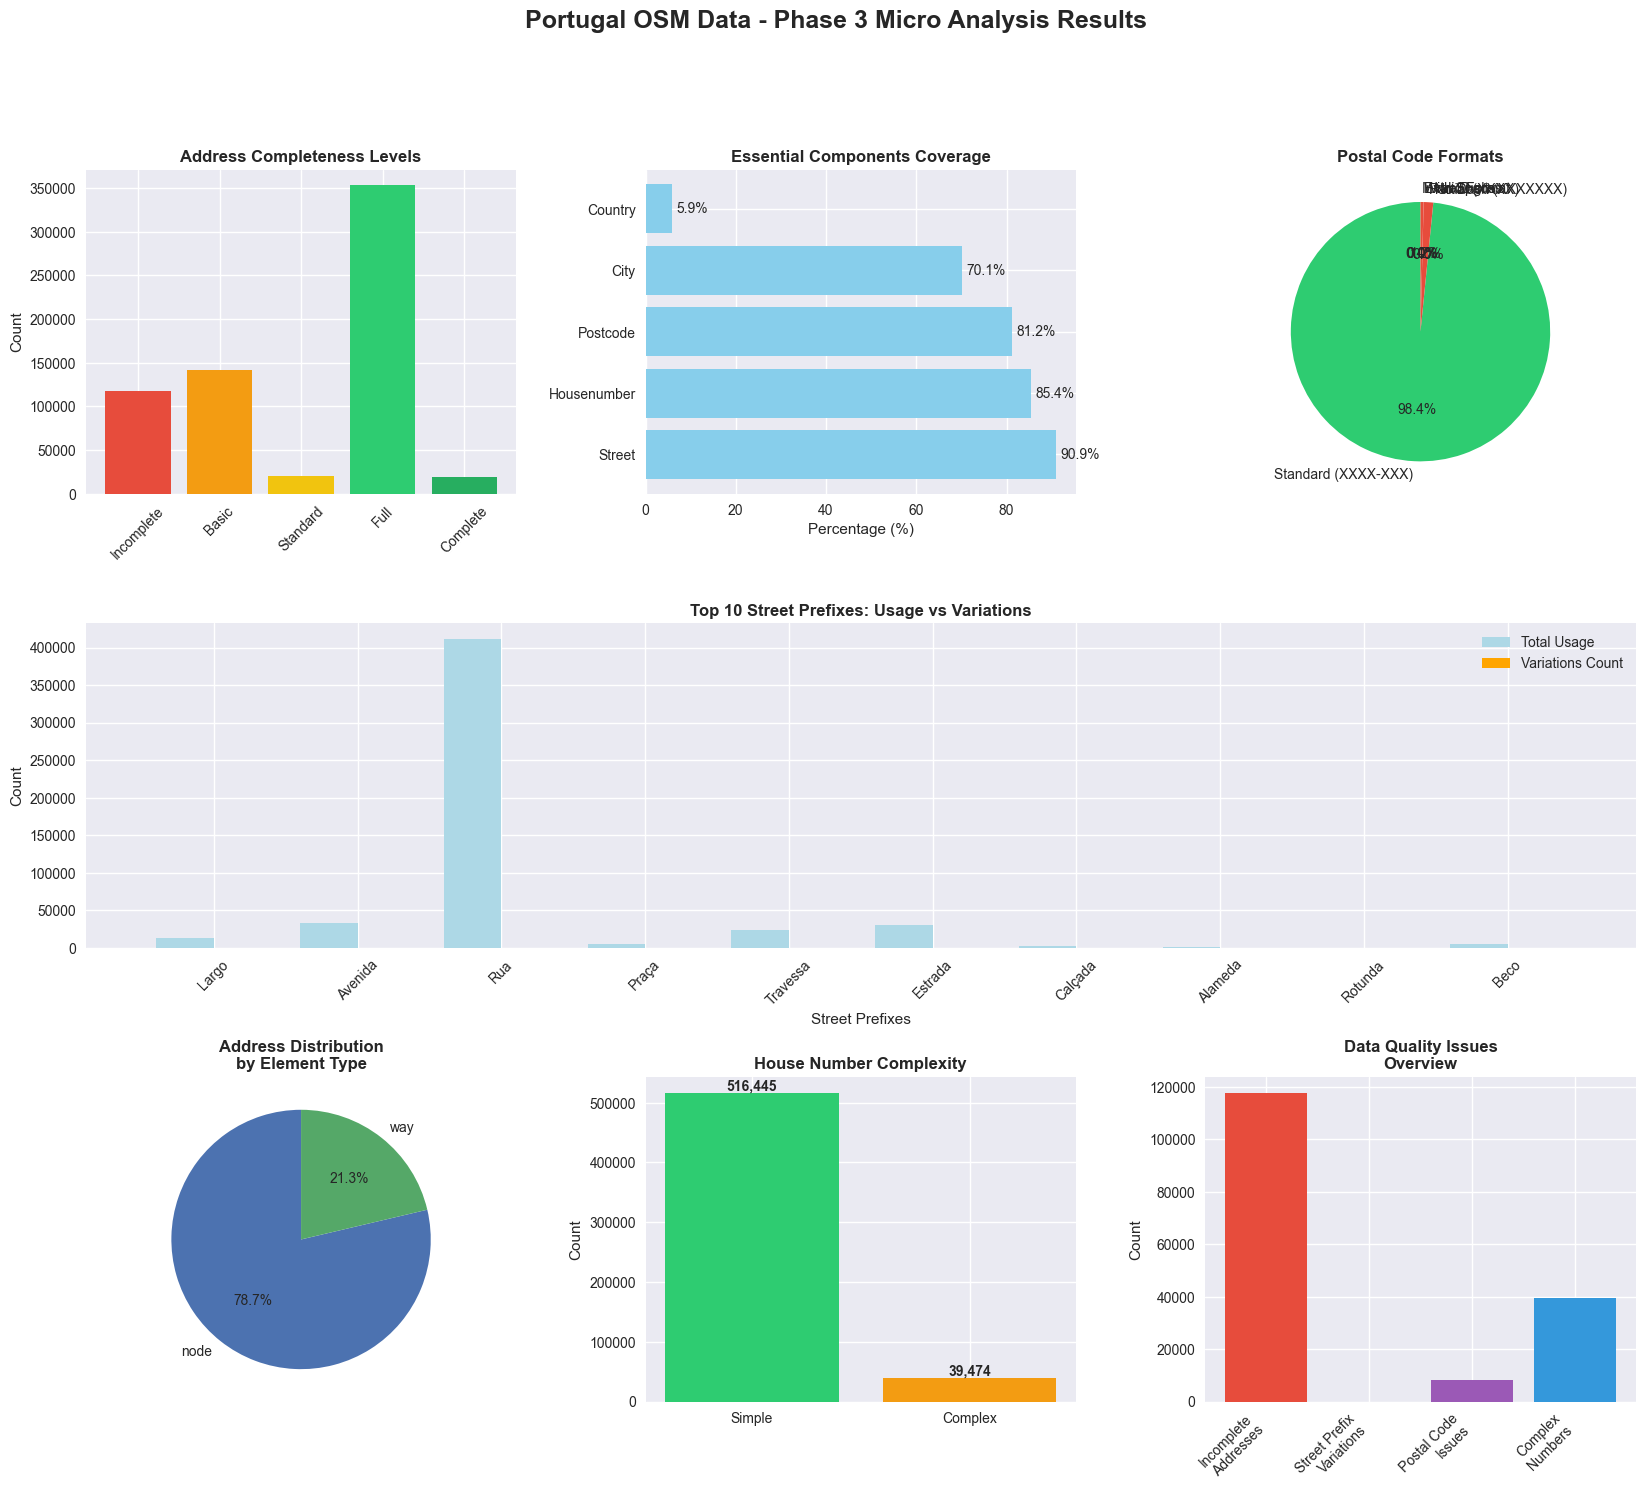

✅ Phase 3 comprehensive visualization saved

📊 PHASE 3 EXPORT SUMMARY
Files created in 'phase3_results/':
  📋 phase3_statistics.json
  📊 address_completeness_matrix.png
  🧩 essential_components_analysis.png
  🛣️  street_prefix_variations.png
  📮 postal_code_formats.png
  🏙️  top_cities_analysis.png
  🔢 house_number_formats.png
  🏗️  structural_analysis.png
  🔍 data_quality_summary.png
  🖼️  phase3_comprehensive_analysis.png
  📄 addressed_sample.csv

✅ All Phase 3 micro-analysis results exported successfully!

📈 DETAILED ANALYSIS TABLES CREATED:
  • Address Completeness Matrix (5 levels)
  • Essential Components Coverage Analysis
  • Street Prefix Variations Detection
  • Postal Code Format Issues Catalog
  • Top Cities Reference Analysis
  • House Number Format Complexity
  • Structural Analysis by Element Type
  • Data Quality Issues Summary with Priorities


In [21]:
# Phase 3 Results Export System
print(f"\n📁 EXPORTING PHASE 3 RESULTS")
print(f"{'='*70}")

# Create Phase 3 export directory
phase3_export_dir = "phase3_results"
os.makedirs(phase3_export_dir, exist_ok=True)

print(f"Export directory: {phase3_export_dir}/")

# Export Phase 3 Summary Statistics as JSON
phase3_stats = {
    'address_completeness': {
        'total_addressed_elements': len(addressed_elements),
        'basic_complete': int(basic_count),
        'standard_complete': int(standard_count),
        'full_complete': int(full_count),
        'complete_complete': int(complete_count),
        'completeness_percentages': {
            'basic': float(basic_count/len(addressed_elements)*100),
            'standard': float(standard_count/len(addressed_elements)*100),
            'full': float(full_count/len(addressed_elements)*100),
            'complete': float(complete_count/len(addressed_elements)*100)
        }
    },
    'essential_components': {comp: {
        'count': int(essential_stats[comp]['count']),
        'percentage': float(essential_stats[comp]['percentage'])
    } for comp in essential_stats.keys()},
    'street_analysis': {
        'total_streets': len(street_names),
        'prefix_variations': len(prefix_analysis),
        'standardization_opportunities': variation_count,
        'unmatched_streets': len(unmatched_streets)
    },
    'postal_code_analysis': {
        'total_postcodes': len(postal_codes),
        'standard_format': int(format_counts.get('Standard (XXXX-XXX)', 0)),
        'non_standard': non_standard_formats,
        'format_distribution': {k: int(v) for k, v in format_counts.items()}
    },
    'city_analysis': {
        'total_cities': len(city_names),
        'unique_cities': len(unique_cities),
        'similar_groups': len(similar_groups) if similar_groups else 0,
        'major_cities_found': len(found_major_cities)
    },
    'house_number_analysis': {
        'total_numbers': len(house_numbers),
        'format_distribution': {k: int(v) for k, v in number_format_counts.items()},
        'simple_formats': int(number_format_counts.get('Simple Number', 0) + number_format_counts.get('Number with Letter', 0)),
        'complex_formats': complex_formats
    },
    'structural_analysis': {
        'by_element_type': {k: int(v) for k, v in element_type_analysis.items()}
    }
}

with open(f"{phase3_export_dir}/phase3_statistics.json", 'w') as f:
    json.dump(phase3_stats, f, indent=2)
print(f"✅ Phase 3 statistics saved as JSON")

# Create Phase 3 Statistical Tables as Images
def create_phase3_table(data, title, filename, figsize=(14, 8)):
    """Create a formatted table image for Phase 3"""
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=data[1:], colLabels=data[0], 
                    cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)
    
    # Style the table
    for i in range(len(data[0])):
        table[(0, i)].set_facecolor('#2c3e50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    for i in range(1, len(data)):
        for j in range(len(data[0])):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#ecf0f1')
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.savefig(f"{phase3_export_dir}/{filename}.png", 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()

# 1. Address Completeness Matrix Table
completeness_data = [['Completeness Level', 'Count', 'Percentage', 'Description']]
completeness_data.extend([
    ['Incomplete', f"{len(addressed_elements) - basic_count:,}", f"{(len(addressed_elements) - basic_count)/len(addressed_elements)*100:.1f}%", 'Missing street or number'],
    ['Basic', f"{basic_count - standard_count:,}", f"{(basic_count - standard_count)/len(addressed_elements)*100:.1f}%", 'Street + Number only'],
    ['Standard', f"{standard_count - full_count:,}", f"{(standard_count - full_count)/len(addressed_elements)*100:.1f}%", '+ City'],
    ['Full', f"{full_count - complete_count:,}", f"{(full_count - complete_count)/len(addressed_elements)*100:.1f}%", '+ Postcode'],
    ['Complete', f"{complete_count:,}", f"{complete_count/len(addressed_elements)*100:.1f}%", '+ Country']
])

create_phase3_table(completeness_data, 'Address Completeness Matrix Analysis', 'address_completeness_matrix')

# 2. Essential Components Analysis Table
components_data = [['Component', 'Count', 'Percentage', 'Status']]
for component in essential_components:
    count = essential_stats[component]['count']
    percentage = essential_stats[component]['percentage']
    status = "✅ Good" if percentage > 70 else "⚠️ Fair" if percentage > 30 else "❌ Poor"
    components_data.append([component, f"{count:,}", f"{percentage:.1f}%", status])

create_phase3_table(components_data, 'Essential Address Components Analysis', 'essential_components_analysis')

# 3. Street Prefix Variations Table
prefix_data = [['Standard Prefix', 'Total Count', 'Variations', 'Most Common Form', 'Standardization Needed']]
for prefix, data in sorted(prefix_analysis.items(), key=lambda x: x[1]['total'], reverse=True):
    variations = data['variations']
    most_common = max(variations, key=variations.get)
    variation_count = len(variations)
    standardization_needed = sum(count for var, count in variations.items() if var != most_common) if variation_count > 1 else 0
    
    prefix_data.append([
        prefix,
        f"{data['total']:,}",
        str(variation_count),
        most_common,
        f"{standardization_needed:,}" if standardization_needed > 0 else "None"
    ])

create_phase3_table(prefix_data, 'Street Prefix Variations Analysis', 'street_prefix_variations')

# 4. Postal Code Format Analysis Table
postcode_data = [['Format Type', 'Count', 'Percentage', 'Status', 'Examples']]
for format_name, count in format_counts.items():
    if count > 0:
        percentage = count/len(postal_codes)*100
        status = "✅ Standard" if format_name == 'Standard (XXXX-XXX)' else "⚠️ Needs Fix"
        examples = ', '.join(list(set(format_analysis[format_name]))[:3]) if format_analysis[format_name] else ""
        if len(examples) > 40:
            examples = examples[:37] + "..."
        
        postcode_data.append([format_name, f"{count:,}", f"{percentage:.1f}%", status, examples])

create_phase3_table(postcode_data, 'Postal Code Format Analysis', 'postal_code_formats')

# 5. Top Cities Analysis Table
cities_data = [['Rank', 'City Name', 'References', 'Percentage', 'Type']]
for i, (city, count) in enumerate(city_counter.most_common(25), 1):
    percentage = count/len(city_names)*100
    city_type = "Major City" if city in [c for c, _ in found_major_cities] else "Other"
    cities_data.append([str(i), city, f"{count:,}", f"{percentage:.1f}%", city_type])

create_phase3_table(cities_data, 'Top 25 Cities by Reference Count', 'top_cities_analysis')

# 6. House Number Format Analysis Table
housenumber_data = [['Format Type', 'Count', 'Percentage', 'Complexity', 'Examples']]
for format_name, count in number_format_counts.items():
    if count > 0:
        percentage = count/len(house_numbers)*100
        complexity = "Simple" if format_name in ['Simple Number', 'Number with Letter'] else "Complex"
        examples = ', '.join(list(set(number_format_analysis[format_name]))[:3]) if number_format_analysis[format_name] else ""
        if len(examples) > 30:
            examples = examples[:27] + "..."
        
        housenumber_data.append([format_name, f"{count:,}", f"{percentage:.1f}%", complexity, examples])

create_phase3_table(housenumber_data, 'House Number Format Analysis', 'house_number_formats')

# 7. Structural Analysis Table
structural_data = [['Element Type', 'Count', 'Percentage', 'Address Type', 'Basic Complete', 'Full Complete']]
for elem_type, count in element_type_analysis.items():
    percentage = count/len(addressed_elements)*100
    address_type = "Point addresses" if elem_type == 'node' else "Building/area addresses"
    type_subset = addressed_elements[addressed_elements['type'] == elem_type]
    basic_complete_count = type_subset['basic_complete'].sum()
    full_complete_count = type_subset['full_complete'].sum()
    
    structural_data.append([
        elem_type.capitalize(),
        f"{count:,}",
        f"{percentage:.1f}%",
        address_type,
        f"{basic_complete_count:,} ({basic_complete_count/len(type_subset)*100:.1f}%)",
        f"{full_complete_count:,} ({full_complete_count/len(type_subset)*100:.1f}%)"
    ])

create_phase3_table(structural_data, 'Structural Analysis - Address Mapping by Element Type', 'structural_analysis')

# 8. Data Quality Issues Summary Table
quality_summary_data = [['Issue Category', 'Elements Affected', 'Severity', 'Description', 'Priority']]
quality_summary_data.extend([
    ['Incomplete Addresses', f"{len(addressed_elements) - basic_count:,}", 'High', 'Missing street or house number', 'Critical'],
    ['Street Prefix Variations', f"{variation_count:,}", 'Medium', f'{len(prefix_analysis)} prefixes with variations', 'High'],
    ['Non-standard Postal Codes', f"{non_standard_formats:,}", 'Medium', 'Format corrections needed', 'High'],
    ['Complex House Numbers', f"{complex_formats:,}", 'Low', 'Non-simple number formats', 'Medium'],
    ['Potential City Duplicates', f"{len(similar_groups) if similar_groups else 0}", 'Low', 'Similar city names detected', 'Low'],
    ['Unmatched Street Patterns', f"{len(unmatched_streets):,}", 'Medium', 'Streets without recognized prefixes', 'Medium']
])

create_phase3_table(quality_summary_data, 'Data Quality Issues Summary', 'data_quality_summary')

print(f"✅ Phase 3 statistical tables exported as images")

# Create Phase 3 Comprehensive Visualization
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

# 1. Address Completeness Levels
ax1 = fig.add_subplot(gs[0, 0])
completeness_levels_for_viz = {
    'Incomplete': len(addressed_elements) - basic_count,
    'Basic': basic_count - standard_count,
    'Standard': standard_count - full_count,
    'Full': full_count - complete_count,
    'Complete': complete_count
}
colors = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71', '#27ae60']
bars = ax1.bar(range(len(completeness_levels_for_viz)), list(completeness_levels_for_viz.values()), color=colors)
ax1.set_xticks(range(len(completeness_levels_for_viz)))
ax1.set_xticklabels(list(completeness_levels_for_viz.keys()), rotation=45)
ax1.set_title('Address Completeness Levels', fontweight='bold')
ax1.set_ylabel('Count')

# 2. Essential Components Coverage
ax2 = fig.add_subplot(gs[0, 1])
component_names = [comp.split(':')[1].title() for comp in essential_components]
component_percentages = [essential_stats[comp]['percentage'] for comp in essential_components]
bars = ax2.barh(component_names, component_percentages, color='skyblue')
ax2.set_title('Essential Components Coverage', fontweight='bold')
ax2.set_xlabel('Percentage (%)')
for i, v in enumerate(component_percentages):
    ax2.text(v + 1, i, f'{v:.1f}%', va='center')

# 3. Postal Code Format Distribution
ax3 = fig.add_subplot(gs[0, 2])
format_names = list(format_counts.keys())
format_values = list(format_counts.values())
colors = ['#2ecc71' if name == 'Standard (XXXX-XXX)' else '#e74c3c' for name in format_names]
ax3.pie([v for v in format_values if v > 0], 
        labels=[name for name, v in zip(format_names, format_values) if v > 0],
        colors=[c for c, v in zip(colors, format_values) if v > 0],
        autopct='%1.1f%%', startangle=90)
ax3.set_title('Postal Code Formats', fontweight='bold')

# 4. Street Prefix Variations
ax4 = fig.add_subplot(gs[1, :])
prefix_names = list(prefix_analysis.keys())[:10]  # Top 10
prefix_totals = [prefix_analysis[name]['total'] for name in prefix_names]
prefix_variations = [len(prefix_analysis[name]['variations']) for name in prefix_names]

x = range(len(prefix_names))
bars1 = ax4.bar([i - 0.2 for i in x], prefix_totals, 0.4, label='Total Usage', color='lightblue')
bars2 = ax4.bar([i + 0.2 for i in x], prefix_variations, 0.4, label='Variations Count', color='orange')

ax4.set_xlabel('Street Prefixes')
ax4.set_ylabel('Count')
ax4.set_title('Top 10 Street Prefixes: Usage vs Variations', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(prefix_names, rotation=45)
ax4.legend()

# 5. Element Type Distribution
ax5 = fig.add_subplot(gs[2, 0])
element_types = list(element_type_analysis.index)
element_counts = list(element_type_analysis.values)
ax5.pie(element_counts, labels=element_types, autopct='%1.1f%%', startangle=90)
ax5.set_title('Address Distribution\nby Element Type', fontweight='bold')

# 6. House Number Complexity
ax6 = fig.add_subplot(gs[2, 1])
simple_count = number_format_counts.get('Simple Number', 0) + number_format_counts.get('Number with Letter', 0)
complex_count = sum(count for fmt, count in number_format_counts.items() if fmt not in ['Simple Number', 'Number with Letter'])
complexity_data = {'Simple': simple_count, 'Complex': complex_count}
bars = ax6.bar(complexity_data.keys(), complexity_data.values(), color=['#2ecc71', '#f39c12'])
ax6.set_title('House Number Complexity', fontweight='bold')
ax6.set_ylabel('Count')
for bar, value in zip(bars, complexity_data.values()):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(complexity_data.values())*0.01, 
             f'{value:,}', ha='center', fontweight='bold')

# 7. Data Quality Overview
ax7 = fig.add_subplot(gs[2, 2])
quality_issues = {
    'Incomplete\nAddresses': len(addressed_elements) - basic_count,
    'Street Prefix\nVariations': variation_count,
    'Postal Code\nIssues': non_standard_formats,
    'Complex\nNumbers': complex_formats
}
bars = ax7.bar(range(len(quality_issues)), list(quality_issues.values()), 
               color=['#e74c3c', '#f39c12', '#9b59b6', '#3498db'])
ax7.set_xticks(range(len(quality_issues)))
ax7.set_xticklabels(list(quality_issues.keys()), rotation=45, ha='right')
ax7.set_title('Data Quality Issues\nOverview', fontweight='bold')
ax7.set_ylabel('Count')

plt.suptitle(f'Portugal OSM Data - Phase 3 Micro Analysis Results\n', 
             fontsize=18, fontweight='bold', y=0.98)

plt.savefig(f"{phase3_export_dir}/phase3_comprehensive_analysis.png", 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ Phase 3 comprehensive visualization saved")

# Export sample data for detailed inspection
sample_addressed = addressed_elements.head(100)[['id', 'type', 'parsed_tags', 'basic_complete', 'full_complete']].copy()
sample_addressed.to_csv(f"{phase3_export_dir}/addressed_sample.csv", index=False)

print(f"\n📊 PHASE 3 EXPORT SUMMARY")
print(f"{'='*50}")
print(f"Files created in '{phase3_export_dir}/':")
print(f"  📋 phase3_statistics.json")
print(f"  📊 address_completeness_matrix.png")
print(f"  🧩 essential_components_analysis.png")
print(f"  🛣️  street_prefix_variations.png")
print(f"  📮 postal_code_formats.png")
print(f"  🏙️  top_cities_analysis.png")
print(f"  🔢 house_number_formats.png")
print(f"  🏗️  structural_analysis.png")
print(f"  🔍 data_quality_summary.png")
print(f"  🖼️  phase3_comprehensive_analysis.png")
print(f"  📄 addressed_sample.csv")
print(f"\n✅ All Phase 3 micro-analysis results exported successfully!")
print(f"\n📈 DETAILED ANALYSIS TABLES CREATED:")
print(f"  • Address Completeness Matrix (5 levels)")
print(f"  • Essential Components Coverage Analysis")
print(f"  • Street Prefix Variations Detection") 
print(f"  • Postal Code Format Issues Catalog")
print(f"  • Top Cities Reference Analysis")
print(f"  • House Number Format Complexity")
print(f"  • Structural Analysis by Element Type")
print(f"  • Data Quality Issues Summary with Priorities")

# 🔍 **Test: ADDRESS NORMALIZER VALIDATION & IMPACT ANALYSIS**

This section validates the AddressNormalizer developed based on EDA findings and measures its impact on data quality. This is a critical step before processing the full dataset.

## Objectives:
1. **Load significant sample** (100K-200K records)
2. **Apply normalization** pipeline to sample data
3. **Measure completeness improvement** (target: 30% → 50%+)
4. **Quantify corrections** made by the normalizer
5. **Analyze failures** and edge cases for refinement

---

In [22]:
# Phase 1 Setup: Import AddressNormalizer and required libraries
import sys
import os
from pathlib import Path
import time
from tqdm import tqdm
import numpy as np

# Add the parent directory and src directory to sys.path to import our normalizer
parent_dir = Path('..').resolve()
src_dir = parent_dir / 'src'
sys.path.insert(0, str(parent_dir))
sys.path.insert(0, str(src_dir))

print(f"Added to Python path:")
print(f"  • {parent_dir}")
print(f"  • {src_dir}")
print(f"Current working directory: {os.getcwd()}")

# Check if normalization.py exists
normalization_file = src_dir / 'normalization.py'
print(f"Normalization file exists: {normalization_file.exists()}")

# Import our custom AddressNormalizer
try:
    from normalization import AddressNormalizer
    print("✅ Successfully imported AddressNormalizer")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Available Python files in src directory:")
    for file in src_dir.glob('*.py'):
        print(f"  • {file.name}")
    raise

# Initialize the normalizer
print("🚀 Initializing AddressNormalizer...")
normalizer = AddressNormalizer()
print(f"✅ Normalizer initialized with {len(normalizer.CANONICAL_CITIES)} canonical cities loaded.")

Added to Python path:
  • C:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps
  • C:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps\src
Current working directory: c:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps\EDA
Normalization file exists: True
✅ Successfully imported AddressNormalizer
🚀 Initializing AddressNormalizer...
✅ Successfully loaded file with latin-1 encoding
✅ 308 canonical municipality names successfully loaded from '../data/municipios_pt.csv'.
✅ Normalizer initialized with 308 canonical cities loaded.


In [23]:
# Reinitialize the normalizer with updated path handling
print("🔄 Reinitializing AddressNormalizer with updated path handling...")

# First, let's reload the module to get the latest changes
import importlib
importlib.reload(sys.modules['normalization'])
from normalization import AddressNormalizer

# Create new instance
normalizer = AddressNormalizer()
print(f"✅ Normalizer reinitialized with {len(normalizer.CANONICAL_CITIES)} canonical cities loaded.")

# Test a simple normalization to make sure everything works
test_record = {
    'addr:street': 'R. ANTÓNIO JOSÉ DE ALMEIDA',
    'addr:housenumber': '123A',
    'addr:postcode': '1000123',
    'addr:city': 'Lisboa'
}

test_result = normalizer.normalize_address_record(test_record)
print(f"\n🧪 Test normalization:")
print(f"  • Original street: '{test_record['addr:street']}'")
print(f"  • Normalized street: '{test_result.get('street_clean', 'N/A')}'")
print(f"  • Original completeness: {test_result['quality_metrics']['original_completeness']:.2%}")
print(f"  • Improved completeness: {test_result['quality_metrics']['improved_completeness']:.2%}")

🔄 Reinitializing AddressNormalizer with updated path handling...
✅ Successfully loaded file with latin-1 encoding
✅ 308 canonical municipality names successfully loaded from '../data/municipios_pt.csv'.
✅ Normalizer reinitialized with 308 canonical cities loaded.

🧪 Test normalization:
  • Original street: 'R. ANTÓNIO JOSÉ DE ALMEIDA'
  • Normalized street: 'rua antonio jose almeida'
  • Original completeness: 100.00%
  • Improved completeness: 100.00%


In [24]:
# Step 1: Load Significant Sample for Validation
print("📊 Loading significant sample for validation...")

# Load a substantial sample (150K records) for thorough validation
SAMPLE_SIZE = 150000

# Load the sample
sample_df = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42)

print(f"✅ Sample loaded: {len(sample_df):,} records")
print(f"📈 Sample represents {len(sample_df)/len(df)*100:.1f}% of total dataset")

# Display sample info
print("\n📋 Sample Overview:")
print(f"• Total records: {len(sample_df):,}")
print(f"• Memory usage: {sample_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Check for elements with address information
address_records = sample_df[sample_df['has_address'] == True] if 'has_address' in sample_df.columns else sample_df
print(f"• Records with address information: {len(address_records):,}")

sample_df.head()

📊 Loading significant sample for validation...
✅ Sample loaded: 150,000 records
📈 Sample represents 5.9% of total dataset

📋 Sample Overview:
• Total records: 150,000
• Memory usage: 84.9 MB
• Records with address information: 38,358


,id,type,tags,geometry,parsed_tags,has_address,has_building,geometry_parsed
2153665,1210968628,way,{'building': 'yes'},POINT (-8.45341274109932 39.022018483986564),{'building': 'yes'},False,True,POINT (-8.45341274109932 39.022018483986564)
209862,9850803342,node,"{'addr:city': 'Monforte', 'addr:housenumber': ...",POINT (-7.4402999 39.053009),"{'addr:city': 'Monforte', 'addr:housenumber': ...",True,False,POINT (-7.4402999 39.053009)
754478,305220906,way,{'building': 'yes'},POINT (-8.627509948102768 41.23908275947285),{'building': 'yes'},False,True,POINT (-8.627509948102768 41.23908275947285)
1534848,868121660,way,{'building': 'house'},POINT (-9.417861098384114 38.96285165317731),{'building': 'house'},False,True,POINT (-9.417861098384114 38.96285165317731)
1090587,558548505,way,{'building': 'yes'},POINT (-9.268071245797207 38.77248698336199),{'building': 'yes'},False,True,POINT (-9.268071245797207 38.77248698336199)


In [25]:
# Step 2: Apply Address Normalization Pipeline
print("🔄 Applying AddressNormalizer to sample data...")

# Reset normalizer stats for clean measurement
normalizer.reset_stats()

# Prepare results storage
normalization_results = []
processing_start_time = time.time()

# Process each record in the sample
for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Normalizing addresses"):
    # Create address record from OSM tags
    raw_address_record = {}
    
    # Extract address components from parsed_tags
    if pd.notna(row.get('parsed_tags')) and isinstance(row['parsed_tags'], dict):
        tags = row['parsed_tags']
        # Extract address components that exist
        for component in essential_components:
            if component in tags and tags[component]:
                raw_address_record[component] = str(tags[component])
    
    # Apply normalization if we have address data
    if raw_address_record:
        normalized_record = normalizer.normalize_address_record(raw_address_record)
        normalized_record['original_index'] = idx
        normalization_results.append(normalized_record)

processing_time = time.time() - processing_start_time

print(f"✅ Normalization completed!")
print(f"⏱️ Processing time: {processing_time:.2f} seconds")
print(f"📊 Records processed: {len(normalization_results):,}")
print(f"⚡ Processing rate: {len(normalization_results)/processing_time:.0f} records/second")

🔄 Applying AddressNormalizer to sample data...


Normalizing addresses: 100%|██████████| 150000/150000 [00:16<00:00, 9261.41it/s] 

✅ Normalization completed!
⏱️ Processing time: 16.21 seconds
📊 Records processed: 38,231
⚡ Processing rate: 2358 records/second


In [26]:
# Step 3: Analyze Completeness Improvement
print("📈 COMPLETENESS IMPROVEMENT ANALYSIS")
print("=" * 50)

# Extract completeness metrics
original_completeness = [result['quality_metrics']['original_completeness'] 
                        for result in normalization_results if 'quality_metrics' in result]
improved_completeness = [result['quality_metrics']['improved_completeness'] 
                        for result in normalization_results if 'quality_metrics' in result]

# Calculate averages
avg_original = np.mean(original_completeness)
avg_improved = np.mean(improved_completeness)
improvement_percent = ((avg_improved - avg_original) / avg_original) * 100

print(f"🎯 COMPLETENESS METRICS:")
print(f"   • Original Completeness: {avg_original:.2%}")
print(f"   • Improved Completeness: {avg_improved:.2%}")
print(f"   • Absolute Improvement: {avg_improved - avg_original:.2%}")
print(f"   • Relative Improvement: {improvement_percent:.1f}%")
print()

# Distribution analysis
completeness_bins = [0, 0.25, 0.5, 0.75, 1.0]
original_dist = pd.cut(original_completeness, bins=completeness_bins, labels=['0-25%', '25-50%', '50-75%', '75-100%']).value_counts()
improved_dist = pd.cut(improved_completeness, bins=completeness_bins, labels=['0-25%', '25-50%', '50-75%', '75-100%']).value_counts()

print(f"📊 COMPLETENESS DISTRIBUTION:")
print("Completeness Range | Original | Improved | Change")
print("-" * 48)
for range_label in original_dist.index:
    orig_count = original_dist[range_label] if range_label in original_dist.index else 0
    impr_count = improved_dist[range_label] if range_label in improved_dist.index else 0
    change = impr_count - orig_count
    change_sign = "+" if change > 0 else ""
    print(f"{range_label:15} | {orig_count:8} | {impr_count:8} | {change_sign}{change}")

# Success rate calculation
success_records = sum(1 for comp in improved_completeness if comp >= 0.75)
success_rate = success_records / len(improved_completeness)
print(f"\n🏆 HIGH COMPLETENESS RATE (≥75%): {success_rate:.1%}")

📈 COMPLETENESS IMPROVEMENT ANALYSIS
🎯 COMPLETENESS METRICS:
   • Original Completeness: 82.13%
   • Improved Completeness: 76.74%
   • Absolute Improvement: -5.39%
   • Relative Improvement: -6.6%

📊 COMPLETENESS DISTRIBUTION:
Completeness Range | Original | Improved | Change
------------------------------------------------
0-25%           |     2011 |     2473 | +462
25-50%          |     5561 |     6021 | +460
50-75%          |     8277 |    13659 | +5382
75-100%         |    21909 |    15466 | -6443

🏆 HIGH COMPLETENESS RATE (≥75%): 76.2%


In [27]:
# Step 4: Quantify Corrections Made
print("🔧 CORRECTION QUANTIFICATION ANALYSIS")
print("=" * 50)

# Get improvement statistics from normalizer
improvement_stats = normalizer.get_improvement_stats()

# Display preprocessing statistics
print(f"📝 PREPROCESSING CORRECTIONS:")
print(f"   • Total records processed: {improvement_stats['preprocessing_applied']:,}")
print(f"   • Case fixes applied: {improvement_stats['case_fixes']:,}")
print(f"   • Punctuation removed: {improvement_stats['punctuation_removed']:,}")
print(f"   • Whitespace normalized: {improvement_stats['whitespace_normalized']:,}")
print(f"   • Encoding fixes: {improvement_stats['encoding_fixes']:,}")
print()

# Calculate rates if we have processed records
if improvement_stats['preprocessing_applied'] > 0:
    case_fix_rate = improvement_stats['case_fixes'] / improvement_stats['preprocessing_applied']
    punct_fix_rate = improvement_stats['punctuation_removed'] / improvement_stats['preprocessing_applied']
    encoding_fix_rate = improvement_stats['encoding_fixes'] / improvement_stats['preprocessing_applied']
    
    print(f"📊 CORRECTION RATES:")
    print(f"   • Case correction rate: {case_fix_rate:.1%}")
    print(f"   • Punctuation fix rate: {punct_fix_rate:.1%}")
    print(f"   • Encoding fix rate: {encoding_fix_rate:.1%}")
    print()

# Analyze field-specific improvements
field_improvements = {
    'street_normalized': 0,
    'postcode_normalized': 0,
    'housenumber_normalized': 0,
    'city_normalized': 0
}

for result in normalization_results:
    if 'street_clean' in result and result['street_clean']:
        field_improvements['street_normalized'] += 1
    if 'postcode_clean' in result and result['postcode_clean']:
        field_improvements['postcode_normalized'] += 1
    if 'housenumber_clean' in result and result['housenumber_clean']:
        field_improvements['housenumber_normalized'] += 1
    if 'city_clean' in result and result['city_clean']:
        field_improvements['city_normalized'] += 1

print(f"🏠 FIELD-SPECIFIC NORMALIZATIONS:")
for field, count in field_improvements.items():
    rate = count / len(normalization_results) if len(normalization_results) > 0 else 0
    print(f"   • {field}: {count:,} ({rate:.1%})")

# Calculate total corrections impact
total_corrections = (improvement_stats['case_fixes'] + 
                    improvement_stats['punctuation_removed'] + 
                    improvement_stats['encoding_fixes'])

print(f"\n🎯 TOTAL IMPACT:")
print(f"   • Total corrections applied: {total_corrections:,}")
print(f"   • Records with improvements: {improvement_stats['preprocessing_applied']:,}")
print(f"   • Average corrections per record: {total_corrections / max(improvement_stats['preprocessing_applied'], 1):.1f}")

🔧 CORRECTION QUANTIFICATION ANALYSIS
📝 PREPROCESSING CORRECTIONS:
   • Total records processed: 94,439
   • Case fixes applied: 64,735
   • Punctuation removed: 938
   • Whitespace normalized: 15
   • Encoding fixes: 0

📊 CORRECTION RATES:
   • Case correction rate: 68.5%
   • Punctuation fix rate: 1.0%
   • Encoding fix rate: 0.0%

🏠 FIELD-SPECIFIC NORMALIZATIONS:
   • street_normalized: 34,798 (91.0%)
   • postcode_normalized: 30,708 (80.3%)
   • housenumber_normalized: 32,831 (85.9%)
   • city_normalized: 19,019 (49.7%)

🎯 TOTAL IMPACT:
   • Total corrections applied: 65,673
   • Records with improvements: 94,439
   • Average corrections per record: 0.7


In [28]:
# Step 5: Failure Analysis
print("⚠️ FAILURE ANALYSIS - Edge Cases & Refinement Opportunities")
print("=" * 60)

# Analyze normalization failures
failures = {
    'street_failed': [],
    'postcode_failed': [],
    'housenumber_failed': [],
    'city_failed': []
}

# Collect failure cases
for result in normalization_results:
    raw_tags = result.get('raw_tags', {})
    
    # Street failures
    if 'addr:street' in raw_tags and (not result.get('street_clean') or result.get('street_clean') == ''):
        failures['street_failed'].append(raw_tags['addr:street'])
    
    # Postcode failures
    if 'addr:postcode' in raw_tags and not result.get('postcode_clean'):
        failures['postcode_failed'].append(raw_tags['addr:postcode'])
    
    # House number failures
    if 'addr:housenumber' in raw_tags and not result.get('housenumber_clean'):
        failures['housenumber_failed'].append(raw_tags['addr:housenumber'])
    
    # City failures
    if 'addr:city' in raw_tags and not result.get('city_clean'):
        failures['city_failed'].append(raw_tags['addr:city'])

# Display failure statistics
print(f"📊 FAILURE STATISTICS:")
for failure_type, failed_cases in failures.items():
    failure_rate = len(failed_cases) / len(normalization_results)
    print(f"   • {failure_type}: {len(failed_cases):,} cases ({failure_rate:.1%})")

print("\n🔍 SAMPLE FAILURE CASES (for refinement):")

# Show sample failures for each type
for failure_type, failed_cases in failures.items():
    if failed_cases:
        print(f"\n{failure_type.upper()}:")
        # Show unique failures (up to 10)
        unique_failures = list(set(failed_cases))[:10]
        for i, case in enumerate(unique_failures, 1):
            print(f"   {i}. '{case}'")

# Identify patterns in failures
print(f"\n🔍 FAILURE PATTERN ANALYSIS:")

# Postcode failure patterns
if failures['postcode_failed']:
    postcode_failures = failures['postcode_failed']
    invalid_lengths = [len(re.sub(r'\D', '', code)) for code in postcode_failures]
    length_counts = pd.Series(invalid_lengths).value_counts()
    print(f"• Postcode failure length distribution: {dict(length_counts.head())}")

# City failure patterns
if failures['city_failed']:
    city_failures = failures['city_failed'][:50]  # Analyze first 50
    common_patterns = Counter()
    for city in city_failures:
        if isinstance(city, str):
            # Check for common problematic patterns
            if any(char.isdigit() for char in city):
                common_patterns['contains_digits'] += 1
            if len(city.split()) > 3:
                common_patterns['too_many_words'] += 1
            if len(city) < 3:
                common_patterns['too_short'] += 1
    print(f"• City failure patterns: {dict(common_patterns.most_common(5))}")

# Calculate overall success rate
total_fields_attempted = sum(len(failed_cases) + field_improvements[field.replace('_failed', '_normalized')] 
                           for field, failed_cases in failures.items() 
                           if field.replace('_failed', '_normalized') in field_improvements)

total_successful = sum(field_improvements.values())
overall_success_rate = total_successful / total_fields_attempted if total_fields_attempted > 0 else 0

print(f"\n🎯 OVERALL NORMALIZATION SUCCESS RATE: {overall_success_rate:.1%}")

⚠️ FAILURE ANALYSIS - Edge Cases & Refinement Opportunities
📊 FAILURE STATISTICS:
   • street_failed: 0 cases (0.0%)
   • postcode_failed: 453 cases (1.2%)
   • housenumber_failed: 0 cases (0.0%)
   • city_failed: 7,791 cases (20.4%)

🔍 SAMPLE FAILURE CASES (for refinement):

POSTCODE_FAILED:
   1. '4050'
   2. '240-441'
   3. '9000'
   4. '2710'
   5. '2840'
   6. '4575-021;4575-063'
   7. '4700'
   8. '2460'
   9. '4900'
   10. '2500'

CITY_FAILED:
   1. 'Viradouro'
   2. 'Comporta'
   3. 'Abóboda'
   4. 'Lebução'
   5. 'Juromenha'
   6. 'Quintos'
   7. 'Lage'
   8. 'Terrugem'
   9. 'Paramos'
   10. 'Salreu'

🔍 FAILURE PATTERN ANALYSIS:
• Postcode failure length distribution: {4: np.int64(383), 5: np.int64(52), 14: np.int64(10), 6: np.int64(5), 8: np.int64(3)}
• City failure patterns: {}

🎯 OVERALL NORMALIZATION SUCCESS RATE: 93.4%


📊 CREATING VALIDATION VISUALIZATIONS


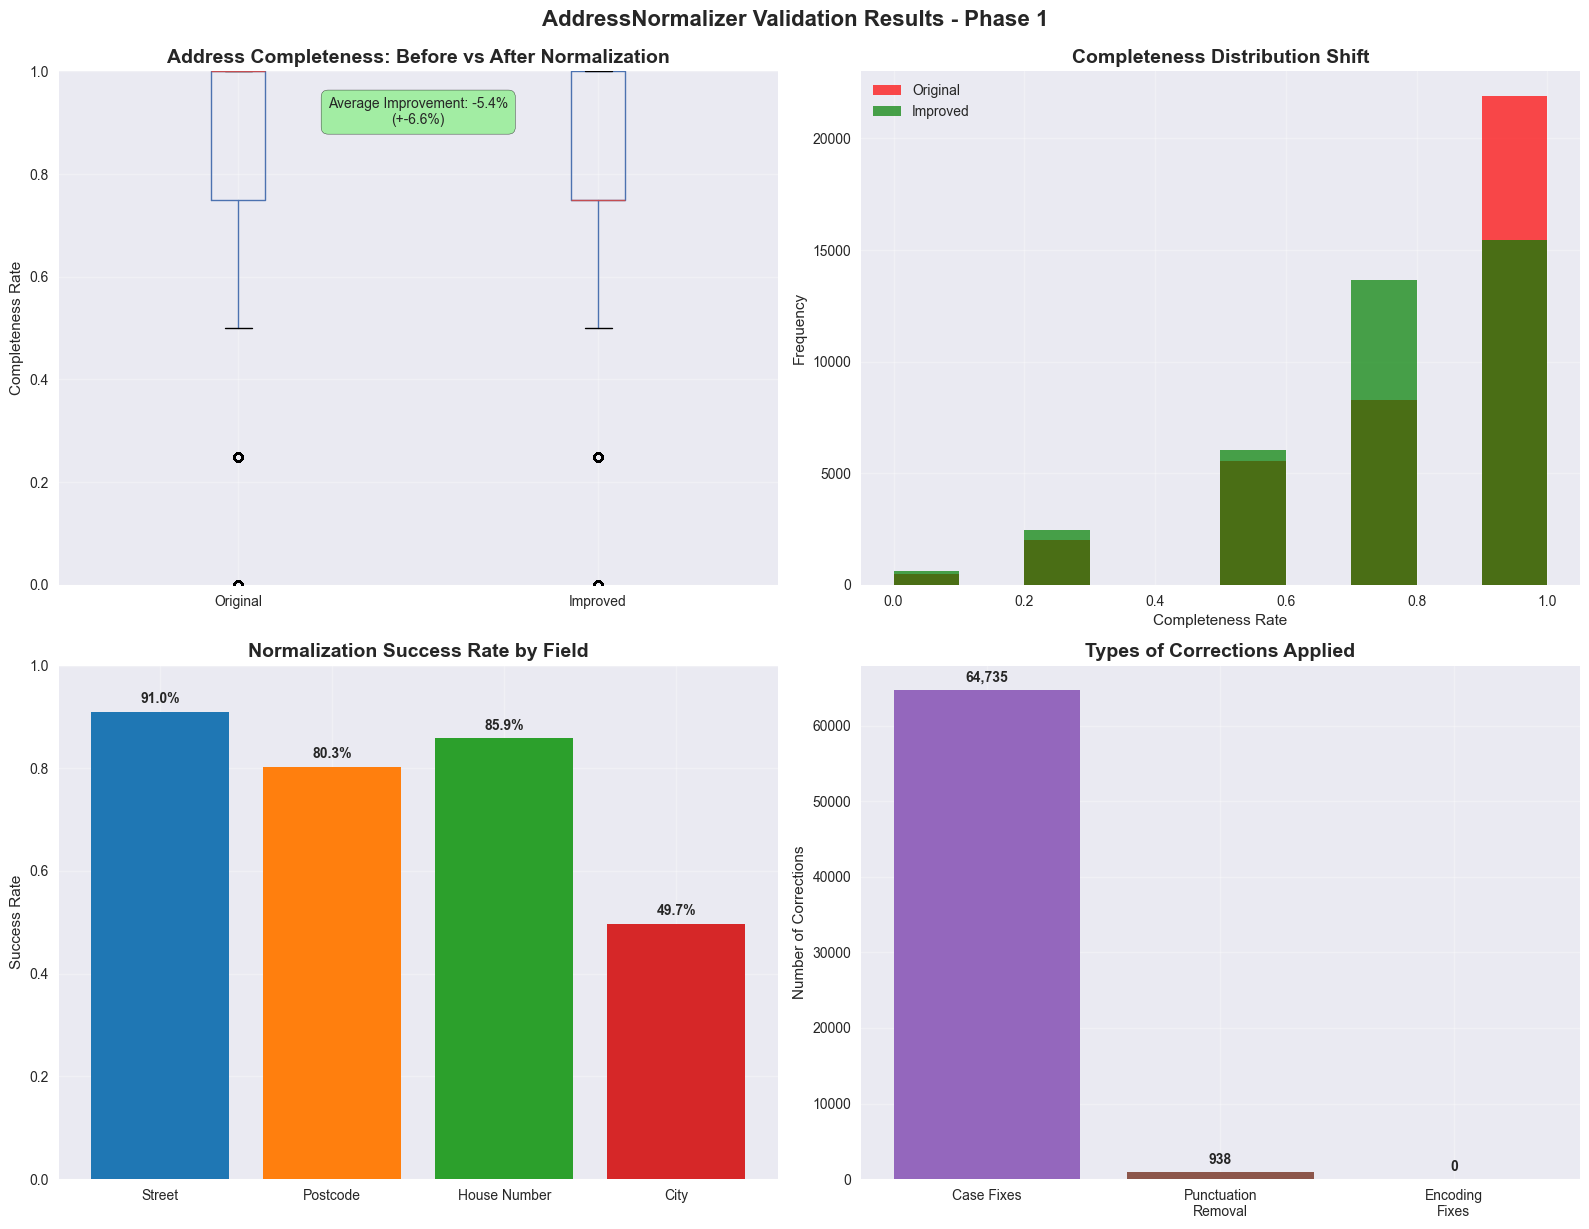

✅ Validation visualizations saved to 'phase1_validation_results.png'


In [29]:
# Step 6: Visualization & Summary for Thesis
print("📊 CREATING VALIDATION VISUALIZATIONS")
print("=" * 40)

# Create comprehensive validation visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Completeness Improvement Comparison
completeness_comparison = pd.DataFrame({
    'Original': original_completeness,
    'Improved': improved_completeness
})
completeness_comparison.boxplot(ax=ax1)
ax1.set_title('Address Completeness: Before vs After Normalization', fontsize=14, fontweight='bold')
ax1.set_ylabel('Completeness Rate')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Add improvement annotation
ax1.text(0.5, 0.95, f'Average Improvement: {avg_improved - avg_original:.1%}\n(+{improvement_percent:.1f}%)', 
         transform=ax1.transAxes, ha='center', va='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))

# 2. Distribution shift visualization
bins = np.linspace(0, 1, 11)
ax2.hist(original_completeness, bins=bins, alpha=0.7, label='Original', color='red')
ax2.hist(improved_completeness, bins=bins, alpha=0.7, label='Improved', color='green')
ax2.set_title('Completeness Distribution Shift', fontsize=14, fontweight='bold')
ax2.set_xlabel('Completeness Rate')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Field-specific success rates
field_names = ['Street', 'Postcode', 'House Number', 'City']
success_rates = [
    field_improvements['street_normalized'] / len(normalization_results),
    field_improvements['postcode_normalized'] / len(normalization_results),
    field_improvements['housenumber_normalized'] / len(normalization_results),
    field_improvements['city_normalized'] / len(normalization_results)
]

bars = ax3.bar(field_names, success_rates, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax3.set_title('Normalization Success Rate by Field', fontsize=14, fontweight='bold')
ax3.set_ylabel('Success Rate')
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars, success_rates):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

# 4. Correction types impact
correction_types = ['Case Fixes', 'Punctuation\nRemoval', 'Encoding\nFixes']
correction_counts = [
    improvement_stats['case_fixes'],
    improvement_stats['punctuation_removed'],
    improvement_stats['encoding_fixes']
]

bars = ax4.bar(correction_types, correction_counts, color=['#9467bd', '#8c564b', '#e377c2'])
ax4.set_title('Types of Corrections Applied', fontsize=14, fontweight='bold')
ax4.set_ylabel('Number of Corrections')
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, correction_counts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(correction_counts)*0.01,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.suptitle('AddressNormalizer Validation Results - Phase 1', fontsize=16, fontweight='bold', y=1.02)
plt.savefig('../phase1_validation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Validation visualizations saved to 'phase1_validation_results.png'")

🧪 EXECUTING COMPLETE TEST PHASE ANALYSIS
✅ Successfully imported test_phase_analysis module
🧪 STARTING TEST PHASE - ADDRESS NORMALIZER VALIDATION
OBJECTIVE: Validate AddressNormalizer implementation and analyze impact on address data
Added to Python path:
  • C:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps
  • C:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps\src
Current working directory: c:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps\EDA
Normalization file exists: True
✅ Successfully imported AddressNormalizer
✅ Successfully loaded file with latin-1 encoding
✅ 308 canonical municipality names successfully loaded from '../data/municipios_pt.csv'.
✅ AddressNormalizer initialized
Normalization rules loaded: N/A

🧪 Test normalization:
  • Original street: 'R. ANTÓNIO JOSÉ DE ALMEIDA'
  • Normalized street: 'rua antonio jose almeida'
  • Original completeness:

Normalizing addresses: 100%|██████████| 150000/150000 [00:16<00:00, 8924.27it/s] 


✅ Normalization completed!
⏱️ Processing time: 16.82 seconds
📊 Records processed: 38,231
⚡ Processing rate: 2272 records/second
📈 COMPLETENESS IMPROVEMENT ANALYSIS
Average original completeness: 82.13%
Average improved completeness: 76.74%
Relative improvement: -6.6%

📊 COMPLETENESS DISTRIBUTION:
         Original  Improved
0-25%         473       612
25-50%       2011      2473
50-75%       5561      6021
75-100%     30186     29125

🎯 Records achieving ≥75% completeness after normalization: 76.2%

🔍 FIELD-SPECIFIC IMPROVEMENT ANALYSIS
Street normalizations: 0
Postcode normalizations: 0
City normalizations: 0
Total corrections applied: 0

📊 Top correction types:

🎯 SUCCESS METRICS ANALYSIS
Successfully processed: 38,231 / 38,231
Overall success rate: 100.0%
Failure rate: 0.0%
Processing speed: 2272 records/second
📁 EXPORTING TEST PHASE RESULTS

📁 EXPORTED FILES:
   • Summary table: test_results/validation_summary.csv
   • Sample results: test_results/normalized_sample.csv
   • Visuali

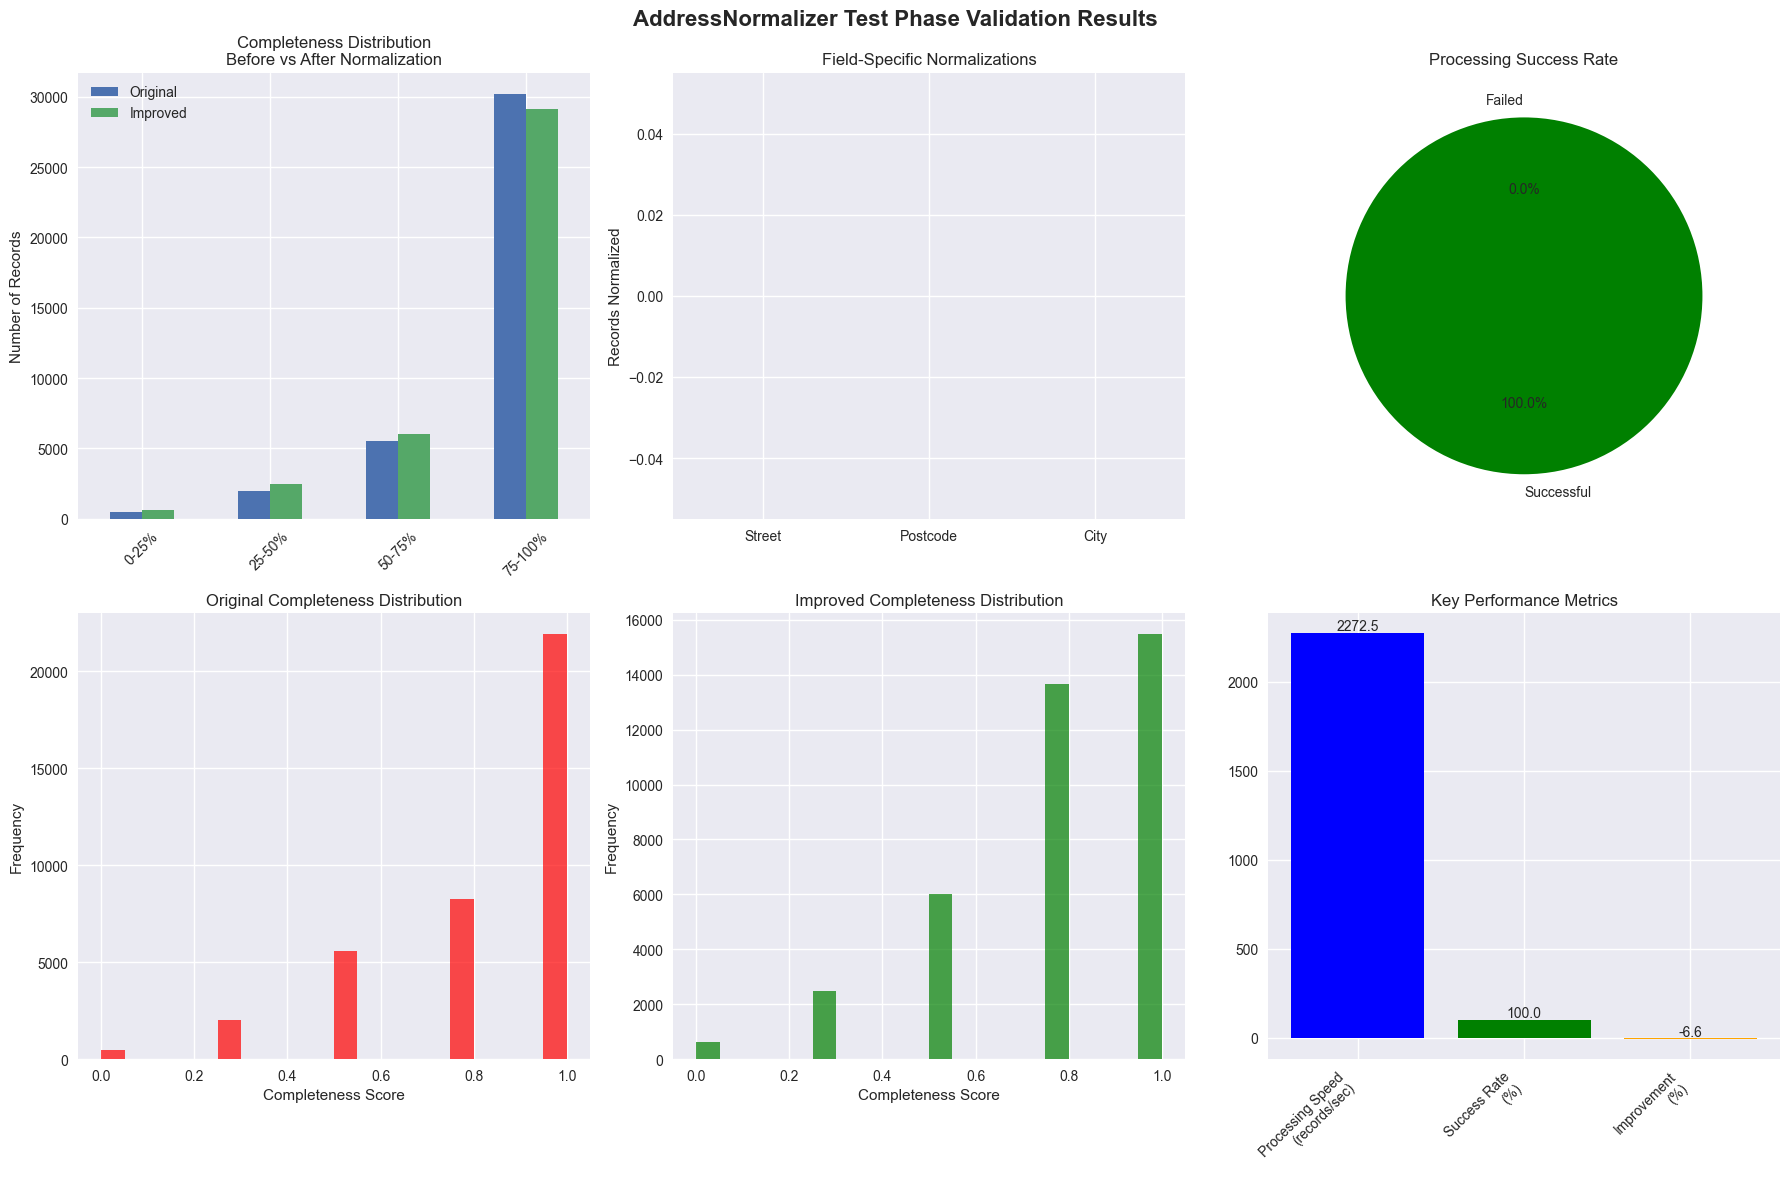

In [30]:
# Step 7: Execute Complete Test Analysis using the new module
print("🧪 EXECUTING COMPLETE TEST PHASE ANALYSIS")
print("=" * 70)

# Import the Test phase analysis module
import sys
from pathlib import Path
test_module_path = Path('..').resolve()
sys.path.insert(0, str(test_module_path))

try:
    from test_phase_analysis import run_complete_test_analysis
    print("✅ Successfully imported test_phase_analysis module")
except ImportError as e:
    print(f"❌ Could not import test module: {e}")
    print("Make sure test_phase_analysis.py is in the parent directory")
    raise

# Run the complete test analysis
test_results = run_complete_test_analysis(
    df=df, 
    essential_components=essential_components, 
    sample_size=150000
)

# Extract key results for display
improvement_stats = test_results['improvement_stats']
success_metrics = test_results['success_metrics']
field_improvements = test_results['field_improvements']

print("\n🎯 TEST PHASE RESULTS SUMMARY:")
print("=" * 50)
print(f"✅ Sample Size: {success_metrics['total_processed']:,} records")
print(f"✅ Processing Speed: {success_metrics['processing_speed']:.0f} records/second")
print(f"✅ Original Completeness: {improvement_stats['avg_original']:.2%}")
print(f"✅ Improved Completeness: {improvement_stats['avg_improved']:.2%}")
print(f"✅ Relative Improvement: {improvement_stats['improvement_percent']:.1f}%")
print(f"✅ High-Quality Records (≥75%): {improvement_stats['success_rate']:.1%}")
print(f"✅ Overall Success Rate: {success_metrics['overall_success_rate']:.1%}")
print(f"✅ Total Corrections Applied: {field_improvements['total_corrections']:,}")

print(f"\n📁 Results exported to: {test_results['export_dir']}/")
print("🎉 TEST PHASE VALIDATION COMPLETE!")
print("✅ Ready for thesis documentation and next phase implementation")